In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def isSameIndex(index, elavuatingNumber):
  index = int(index)
  elavuatingNumber = int(elavuatingNumber[7:10])
  # print('index => ', index, 'evaluatingNumber => ', elavuatingNumber)
  if (index == elavuatingNumber):
    return True
  else:
    return False

In [3]:
def processClassificationReports(dir):
  dates = os.listdir(dir)
  # print('DATES => ', dates)

  dict_classification_reports = {}

  for date in dates:
    list_files = {}
    print('Processing date: ', date)

    for file in os.listdir(dir + date):
      try:
        if file.endswith('.csv'):
          # print('FILE => ', file)
          path = dir + date + '/' + file
          dict_file = {}

          df = pd.read_csv(path)
          # dict_file[file] = df
          list_files[file] = df
      except Exception as e:
        print('Error processing file: ', date, file, ' => ', e)
      
    dict_classification_reports[date] = list_files

  return dict_classification_reports

In [4]:
def reorganizeClassificationReportKeys(dict_classification_reports):
  for date, files in dict_classification_reports.items():
    print('Processing date: ', date)
    # print('FILES => ', list(files))
    df_behaviors = files.get('summary.csv')
    df_behaviors = df_behaviors.drop('Unnamed: 0', axis=1).set_index('Index')
    
    aux_dict = {}
    score_dict = {}
    for name, data in files.items():
      if (name == 'summary.csv'):
        continue
      else:
        # print(df_behaviors)
        for index in df_behaviors.index:
            check = isSameIndex(index, name)
            if (check == True):           
              behavior = df_behaviors['Emergent Behavior'][index]

              if ('Train/Test Score' in df_behaviors.columns):
                train_test_score = df_behaviors['Train/Test Score'][index]
              else:
                train_test_score = None

              aux_dict[name] = behavior
              score_dict[name] = train_test_score
              # score_dict[name] = {}
              # score_dict[name]['score'] = train_test_score
              # score_dict[name]['date'] = date
              # files[newKey] = files.pop(name)
              # print(index, name, newKey)

    files.pop('summary.csv')

    for name in list(files.keys()):
      try:
        newKey = aux_dict[name]
        # print('OLD KEY => ', name, 'NEW KEY => ', newKey)
        files[newKey] = files.pop(name)
        score_dict[newKey] = score_dict.pop(name)
        # print('DONE')
      except:
        print('ERROR')
        print('oldKey => ', name, 'newKey => ', newKey)

    for name, data in files.items():
      df_aux = data.rename({'Unnamed: 0': 'Results'}, axis=1)
      df_aux = df_aux.set_index('Results')
      files[name] = {
          'classification_report': df_aux,
          'train_test_score': score_dict[name]
      }

  return dict_classification_reports

In [5]:
def printClassificationReports(dict_classification_reports):
  for date, files in dict_classification_reports.items():
    print('DATE: ', date)
    print()
    for name, data in files.items():
      print('BEHAVIOR: ', name)
      if (data['train_test_score'] != None):
          print('TRAIN/TEST SCORE: ', data['train_test_score'])
      print('CLASSIFICATION REPORT')
      print(data['classification_report'])
      print()
    print()

In [6]:
def regroupDFsForEmergentBehaviors(dict_classification_reports):
  dict_emergent_behaviors = {}

  for date, files in dict_classification_reports.items():
    for name, data in files.items():
      dict_emergent_behaviors[name] = []

  for date, files in dict_classification_reports.items():
    for name, data in files.items():
      dict_df = {}
      dict_df['date'] = date
      dict_df['classification_report'] = data['classification_report']
      dict_df['train_test_score'] = data['train_test_score']
      dict_emergent_behaviors[name].append(dict_df)

  for behavior, datalist in dict_emergent_behaviors.items():
    sorted_datalist = sorted(datalist, key=lambda d: d['date']) 
    dict_emergent_behaviors[behavior] = sorted_datalist

  return dict_emergent_behaviors

In [7]:
def printEmergentBehaviors(dict_emergent_behaviors):
  for behavior, datalist in dict_emergent_behaviors.items():
    print('BEHAVIOR: ', behavior)
    print()
    for element in datalist:
      for value in element.values():
        print(value)
        print()
      print()
    print()

In [8]:
def generatePlots(dict_emergent_behaviors):
  for behavior, datalist in dict_emergent_behaviors.items():
    for element in datalist:
      for key, df in element.items():
        flag = False
        if (key == 'date'):
          continue
        elif (key == 'classification_report'):
          if not ('1.0' in df.index.values):
            df.loc['1.0'] = [0,0,0,0]
            flag = True
          if not ('0.0' in df.index.values): 
            df.loc['0.0'] = [0,0,0,0]
            flag = True
            
          if flag == True:
            df.loc['macro avg'] = df.loc[['0.0','1.0']].mean()
            df['support']['macro avg'] = df['support']['macro avg'] * 2
            flag = False
        else:
          continue
      
  for behavior, metrics_list in dict_emergent_behaviors.items():
    behavior_example = behavior
    
    dates = []

    for i in range(len(metrics_list)):
      date = metrics_list[i]['date'][:-10].replace('_',':')
      dates.append(date)

    zero_class_precisions = [metrics_list[i]['classification_report']['precision']['0.0'] for i in range(len(metrics_list))]
    one_class_precisions = [metrics_list[i]['classification_report']['precision']['1.0']for i in range(len(metrics_list))]
    accuracies = [metrics_list[i]['classification_report']['f1-score']['accuracy'] for i in range(len(metrics_list))]
    macro_avg_precisions = [metrics_list[i]['classification_report']['precision']['macro avg'] for i in range(len(metrics_list))]
    macro_avg_recalls = [metrics_list[i]['classification_report']['recall']['macro avg'] for i in range(len(metrics_list))]
    macro_avg_f1_score = [metrics_list[i]['classification_report']['f1-score']['macro avg'] for i in range(len(metrics_list))]
    weighted_avg_precisions = [metrics_list[i]['classification_report']['precision']['weighted avg'] for i in range(len(metrics_list))]
    weighted_avg_recalls = [metrics_list[i]['classification_report']['recall']['weighted avg'] for i in range(len(metrics_list))]
    weighted_avg_f1_score = [metrics_list[i]['classification_report']['f1-score']['weighted avg'] for i in range(len(metrics_list))]

    line_chart_zero_class_precisions = plt.plot(dates, zero_class_precisions, label='Precision (Class 0)', color='Blue')
    line_chart_one_class_precisions = plt.plot(dates, one_class_precisions, label='Precision (Class 1)', color='Red')
    line_chart_accuracies = plt.plot(dates, accuracies, label='Accuracy', color='Green')
    line_chart_macro_avg_precisions = plt.plot(dates, macro_avg_precisions, label='Macro AVG (Precision)', color='Orange')
    line_chart_macro_avg_recalls = plt.plot(dates, macro_avg_recalls, label='Macro AVG (Recall)', color='Brown')
    line_chart_macro_avg_f1_score = plt.plot(dates, macro_avg_f1_score, label='Macro AVG (F1-Score)', color='Black')
    line_chart_macro_avg_precisions = plt.plot(dates, weighted_avg_precisions, label='Weighted AVG (Precision)', color='Pink')
    line_chart_macro_avg_recalls = plt.plot(dates, weighted_avg_recalls, label='Weighted AVG (Recall)', color='Purple')
    line_chart_macro_avg_f1_score = plt.plot(dates, weighted_avg_f1_score, label='Weighted AVG (F1-Score)', color='Gray')

    plt.xlabel('Dates', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    plt.ylabel('Metric', fontsize=14)

    plt.title(behavior_example, fontsize=20)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    zero_supports = [metrics_list[i]['classification_report']['support']['0.0'] for i in range(len(metrics_list))]
    one_supports = [metrics_list[i]['classification_report']['support']['1.0'] for i in range(len(metrics_list))]

    line_chart_zero_supports = plt.plot(dates, zero_supports, label='Support (Class 0)', color='Blue')
    line_chart_one_supports = plt.plot(dates, one_supports, label='Support (Class 1)', color='Red')

    plt.xlabel('Dates', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    plt.ylabel('Metric', fontsize=14)

    plt.title(behavior_example, fontsize=20)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    train_test_score = [metrics_list[i]['train_test_score'] for i in range(len(metrics_list))]

    line_train_test_score = plt.plot(dates, train_test_score, label='Train/Test Score', color='Red')

    plt.xlabel('Dates', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    plt.ylabel('Metric', fontsize=14)

    plt.title(behavior_example, fontsize=20)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [9]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
# STORE FILES FROM FOLDER "etl_data_source" IN A GOOGLE DRIVE AND PUT THE PATH BELOW
classification_reports_folder = ""
confusion_matrices_folder = ""

In [11]:
dict_classification_reports = processClassificationReports(classification_reports_folder)

Processing date:  2023-02-15T02_47_58.586933
Processing date:  2023-02-13T21_40_38.918684
Processing date:  2023-02-15T02_52_44.823184
Processing date:  2023-02-15T13_10_08.236553
Processing date:  2023-02-27T17_06_52.138420
Processing date:  2023-02-15T22_21_03.988545
Processing date:  2023-02-15T03_50_25.803780
Processing date:  2023-02-15T03_50_25.560976
Processing date:  2023-03-01T19_48_11.402118
Processing date:  2023-02-15T20_26_31.969261
Processing date:  2023-02-15T21_24_02.447380


In [12]:
dict_classification_reports = reorganizeClassificationReportKeys(dict_classification_reports)

Processing date:  2023-02-15T02_47_58.586933
Processing date:  2023-02-13T21_40_38.918684
Processing date:  2023-02-15T02_52_44.823184
Processing date:  2023-02-15T13_10_08.236553
Processing date:  2023-02-27T17_06_52.138420
Processing date:  2023-02-15T22_21_03.988545
Processing date:  2023-02-15T03_50_25.803780
Processing date:  2023-02-15T03_50_25.560976
Processing date:  2023-03-01T19_48_11.402118
Processing date:  2023-02-15T20_26_31.969261
Processing date:  2023-02-15T21_24_02.447380


In [13]:
sorted_keys = sorted(dict_classification_reports.keys())
sorted_dict = {key: dict_classification_reports[key] for key in sorted_keys}

In [14]:
printClassificationReports(sorted_dict)

DATE:  2023-02-13T21_40_38.918684

BEHAVIOR:  minimum peak loads emerging
CLASSIFICATION REPORT
              precision    recall  f1-score  support
Results                                             
0.0                 1.0  0.190476  0.320000     21.0
1.0                 0.0  0.000000  0.000000      0.0
accuracy            NaN       NaN  0.190476     21.0
macro avg           0.5  0.095238  0.160000     21.0
weighted avg        1.0  0.190476  0.320000     21.0

BEHAVIOR:  Different responses according to different demand/response schemes (price-based)
CLASSIFICATION REPORT
              precision    recall  f1-score  support
Results                                             
0.0                 1.0  0.333333  0.500000     21.0
1.0                 0.0  0.000000  0.000000      0.0
accuracy            NaN       NaN  0.333333     21.0
macro avg           0.5  0.166667  0.250000     21.0
weighted avg        1.0  0.333333  0.500000     21.0

BEHAVIOR:  deploy batteries in different ways 

In [15]:
dict_emergent_behaviors = regroupDFsForEmergentBehaviors(dict_classification_reports)

In [16]:
printEmergentBehaviors(dict_emergent_behaviors)

A saída de streaming foi truncada nas últimas 5000 linhas.
0.0                 1.0  0.042553  0.081633     47.0
1.0                 0.0  0.000000  0.000000      0.0
accuracy            NaN       NaN  0.042553     47.0
macro avg           0.5  0.021277  0.040816     47.0
weighted avg        1.0  0.042553  0.081633     47.0

None


2023-02-27T17_06_52.138420

              precision    recall  f1-score  support
Results                                             
0.0                 1.0  0.666667  0.800000     51.0
1.0                 0.0  0.000000  0.000000      0.0
accuracy            NaN       NaN  0.666667     51.0
macro avg           0.5  0.333333  0.400000     51.0
weighted avg        1.0  0.666667  0.800000     51.0

None


2023-03-01T19_48_11.402118

              precision    recall  f1-score  support
Results                                             
0.0                 1.0  0.965517  0.982456     58.0
1.0                 0.0  0.000000  0.000000      0.0
accuracy            N

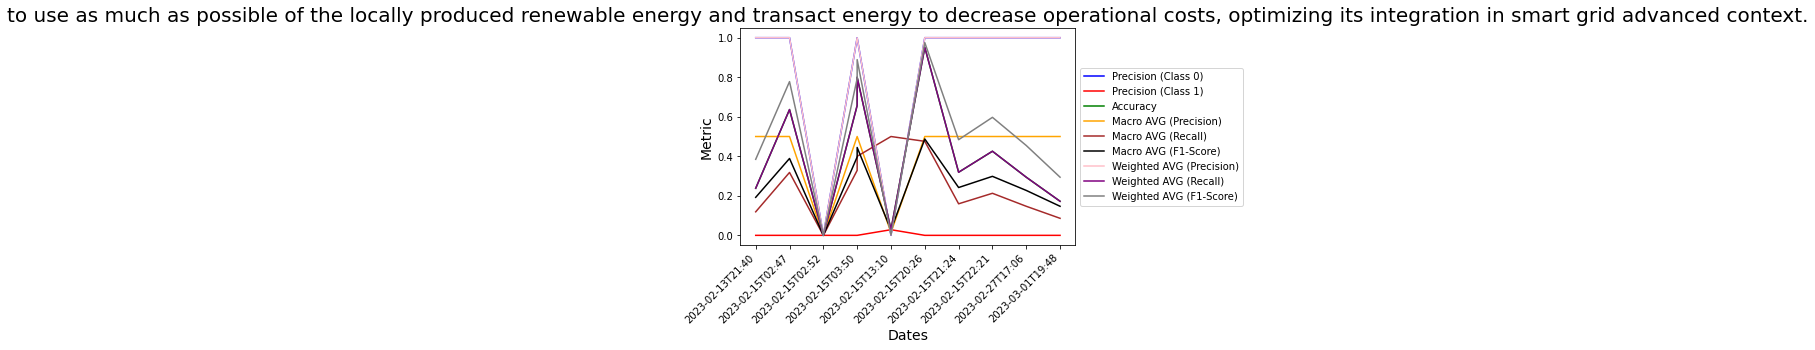

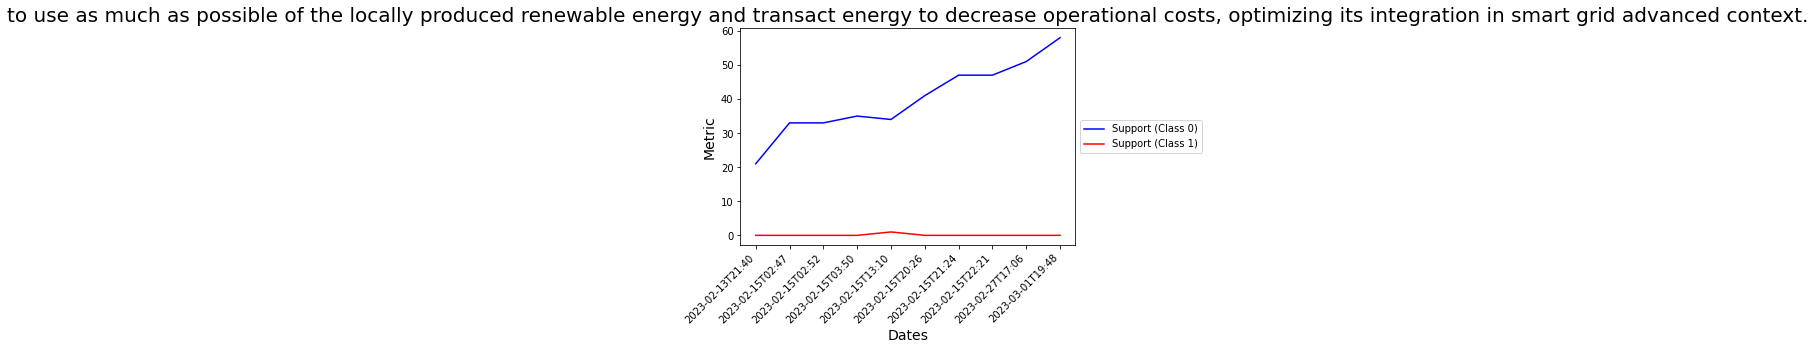

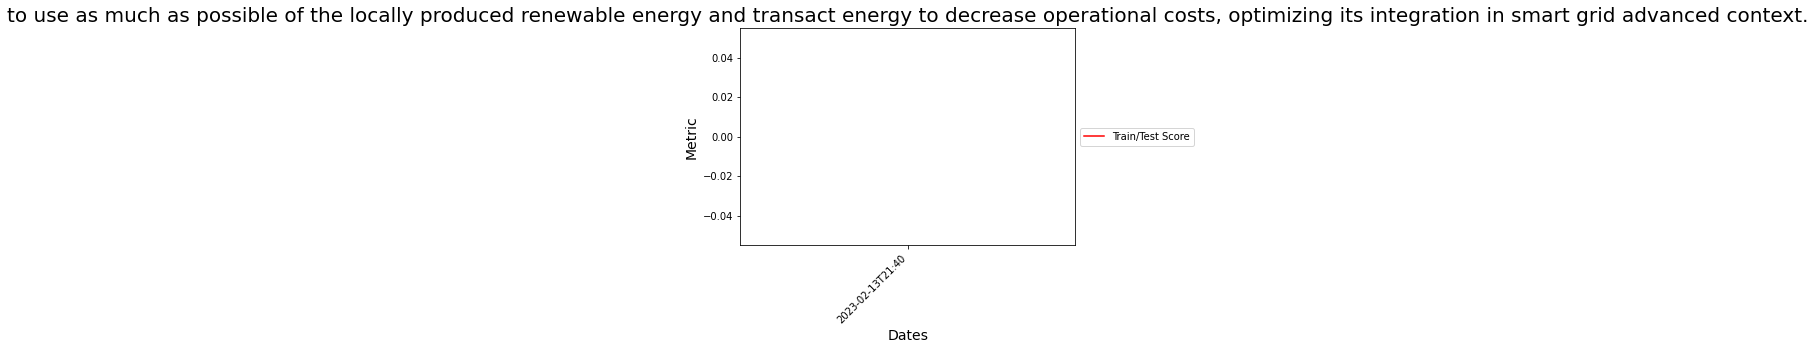

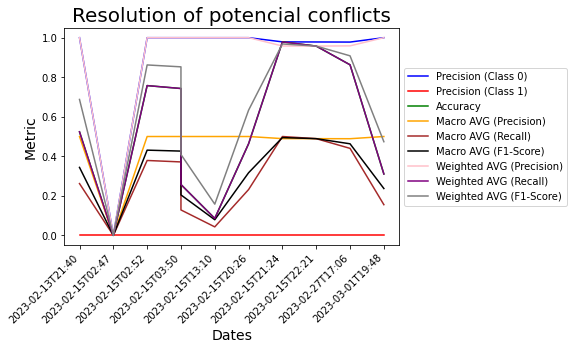

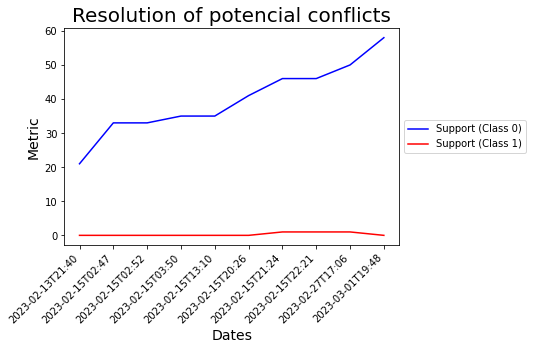

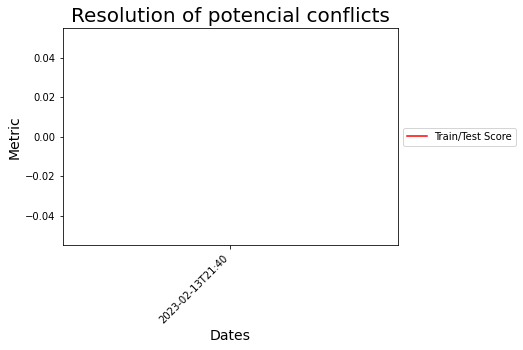

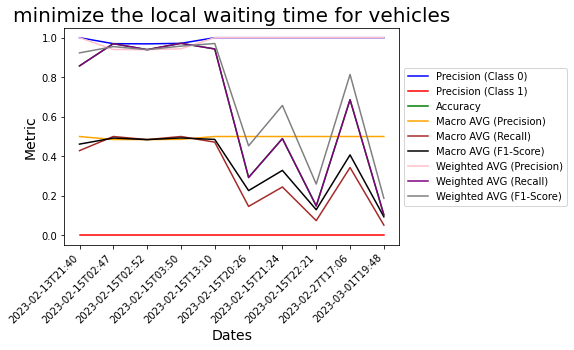

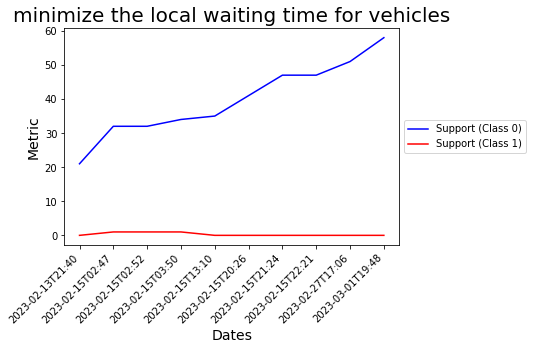

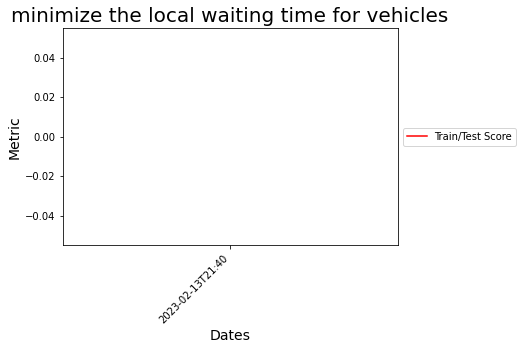

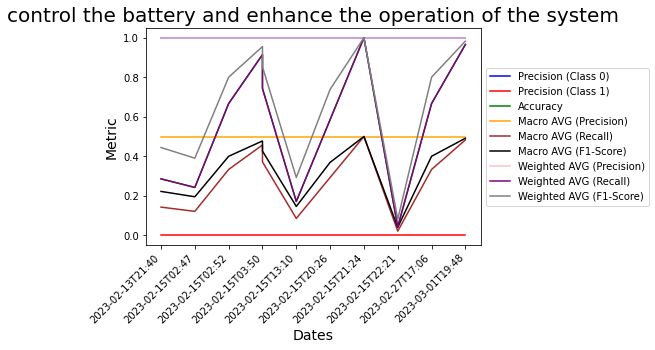

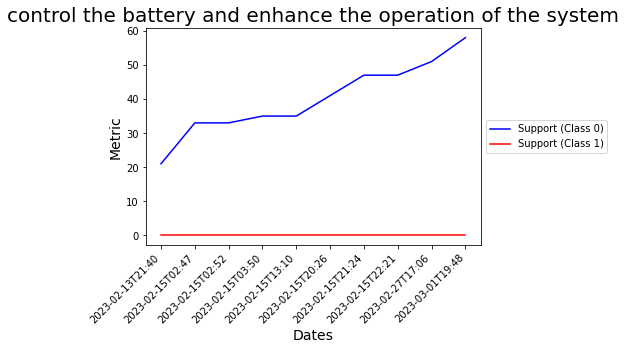

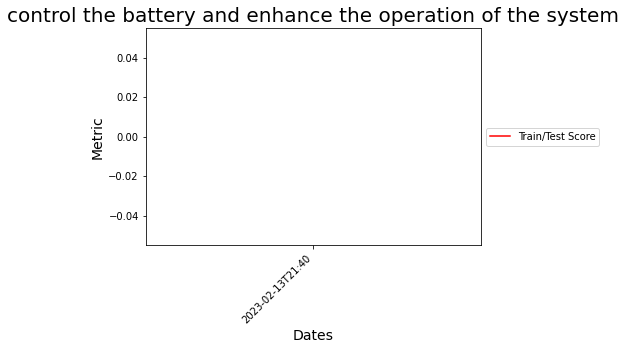

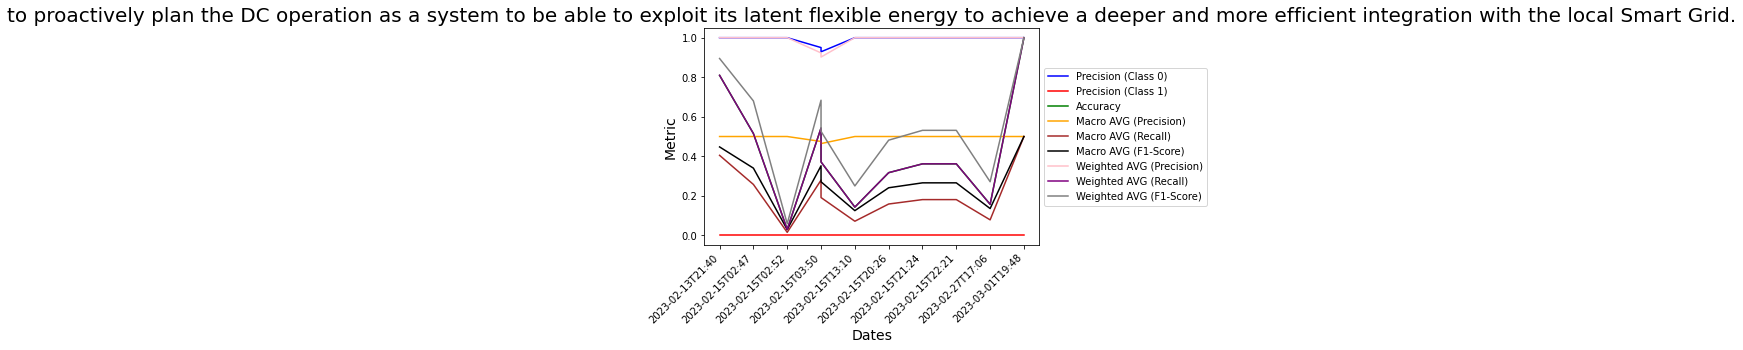

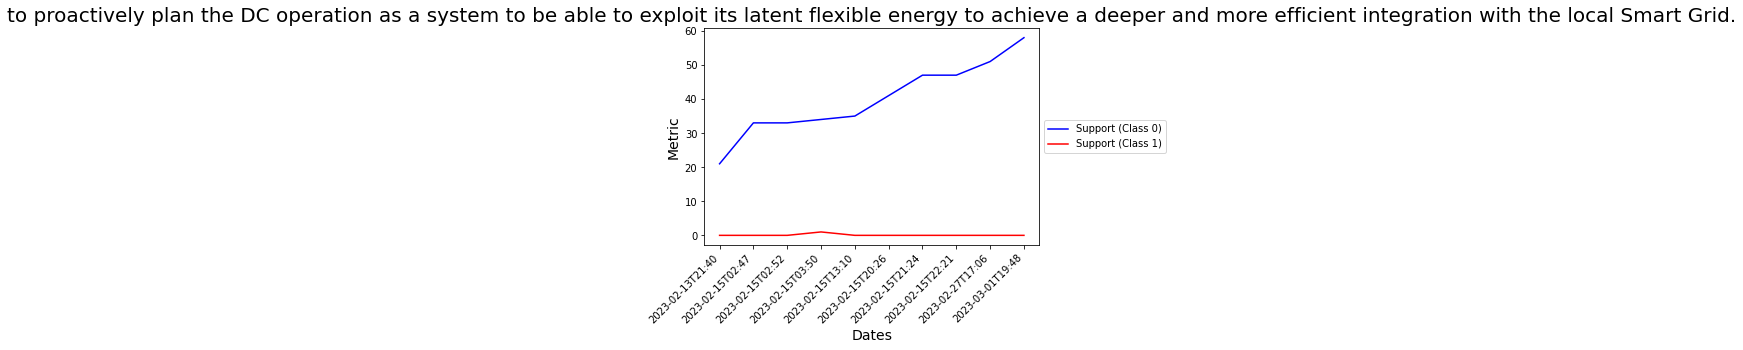

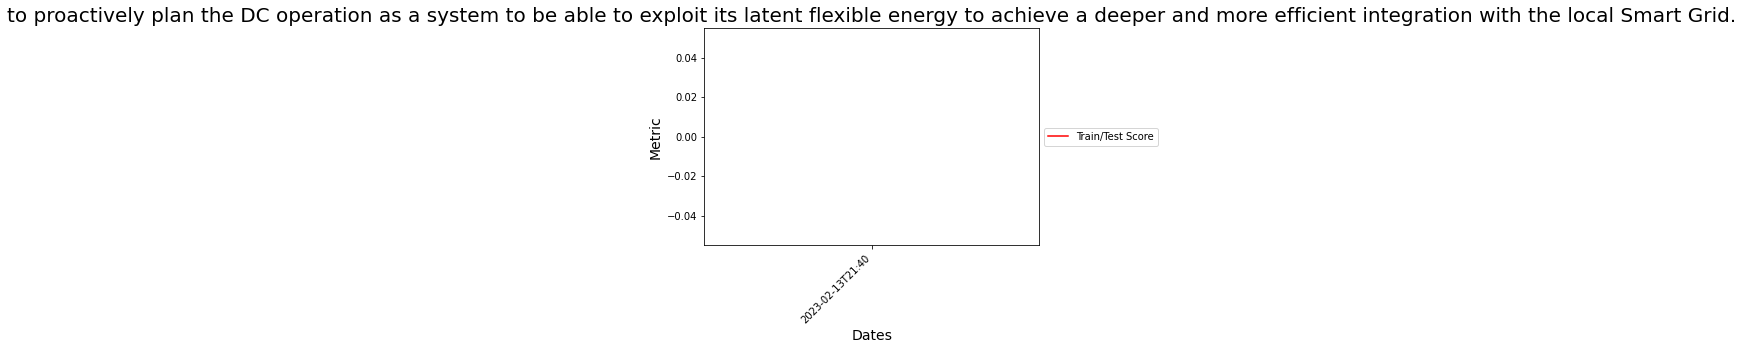

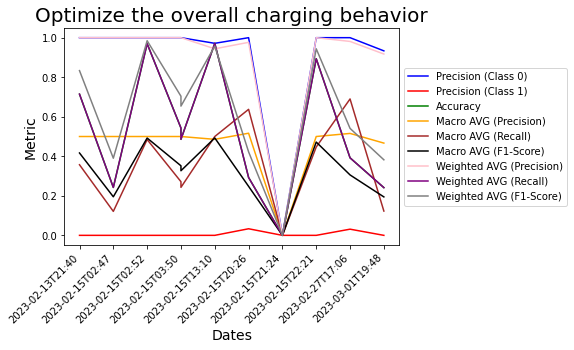

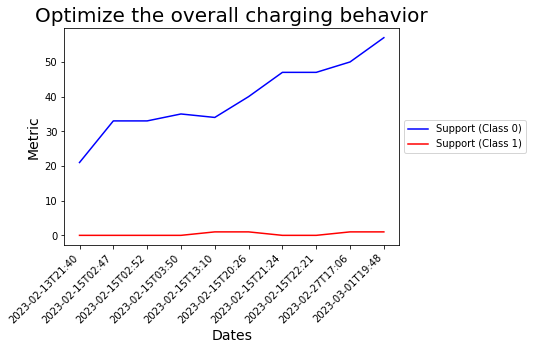

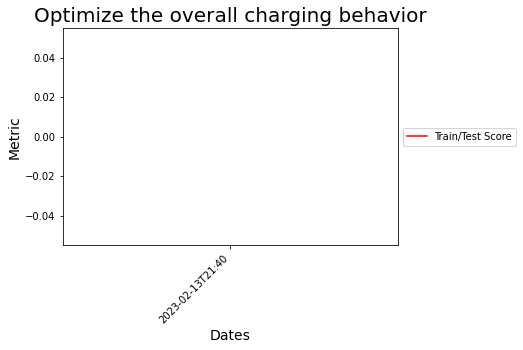

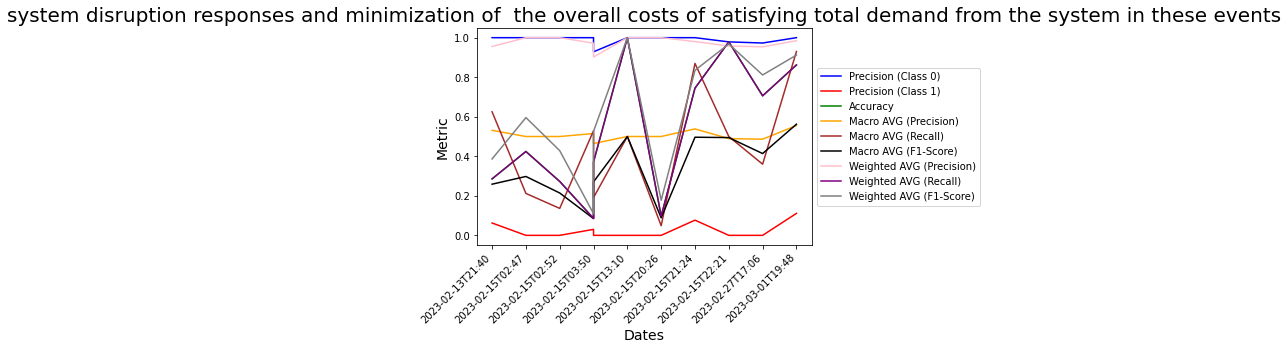

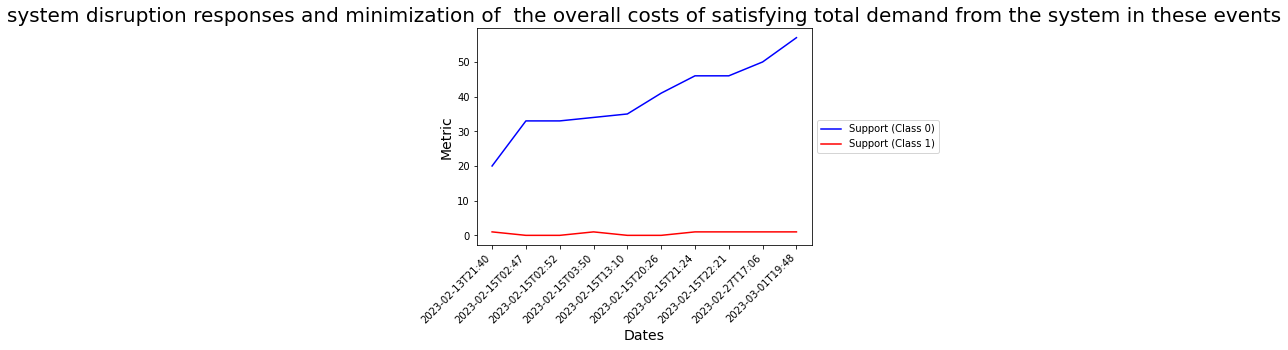

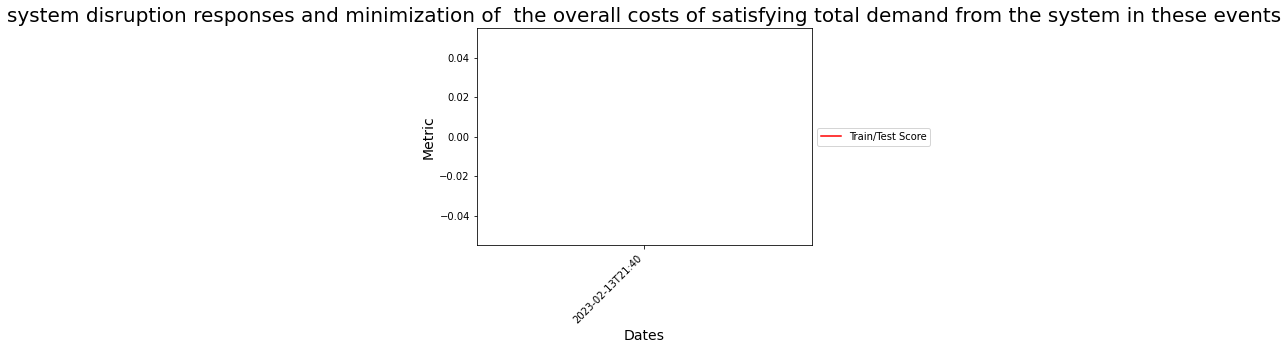

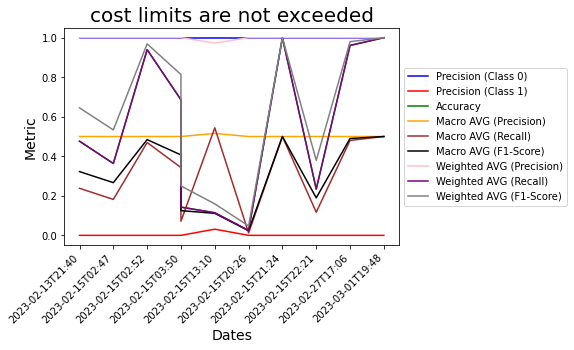

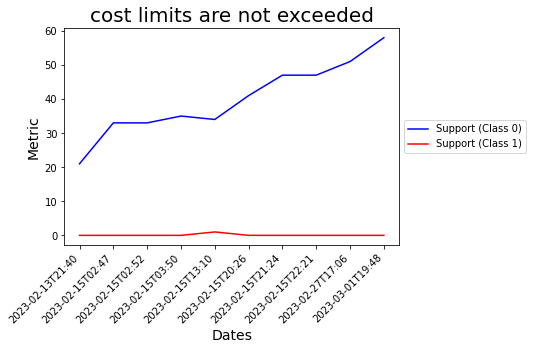

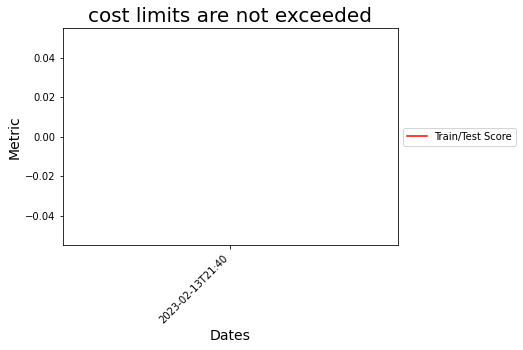

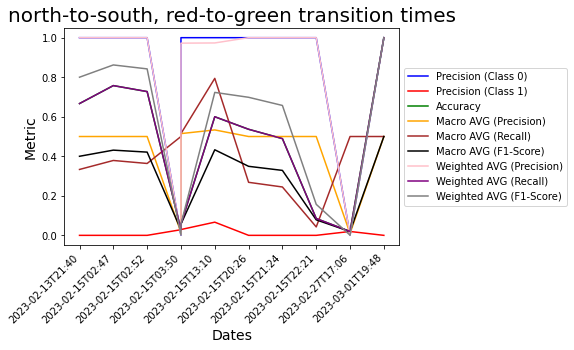

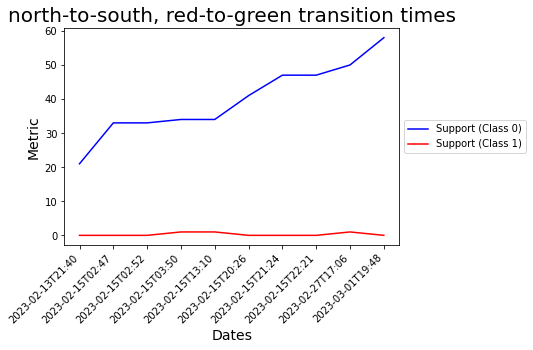

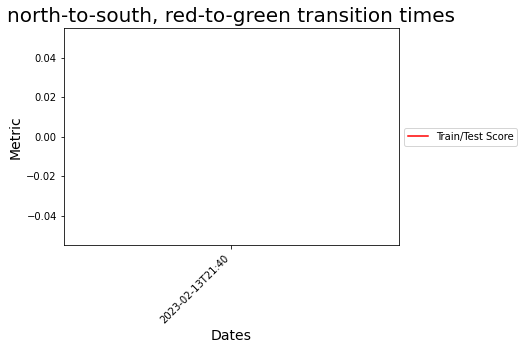

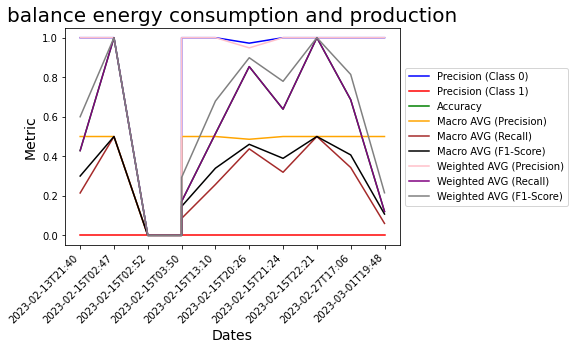

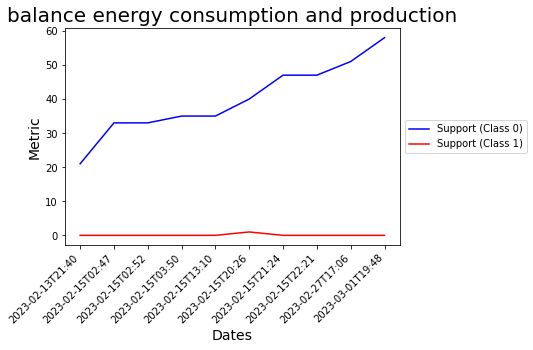

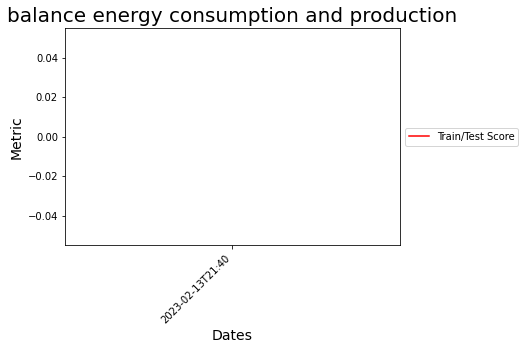

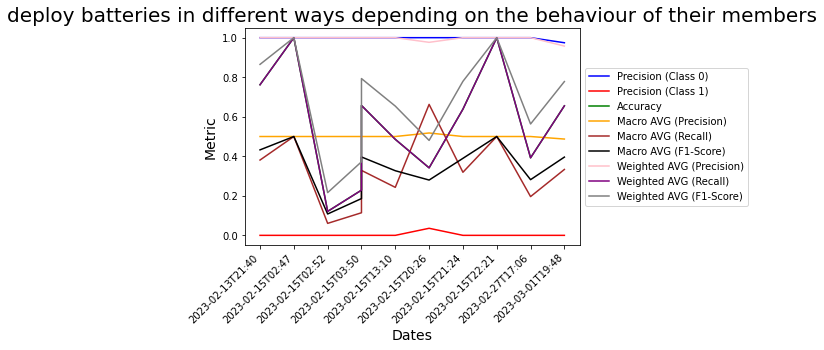

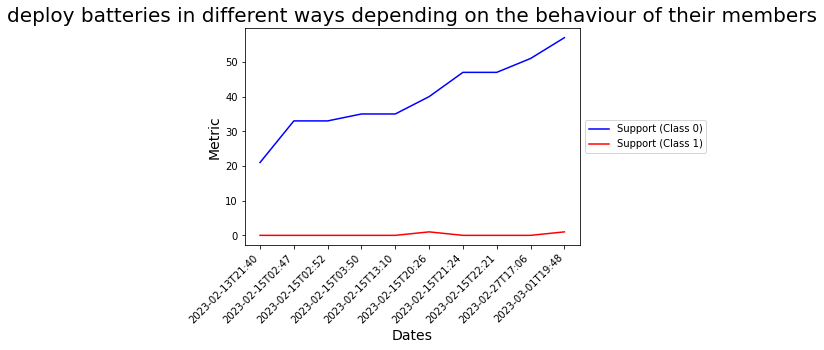

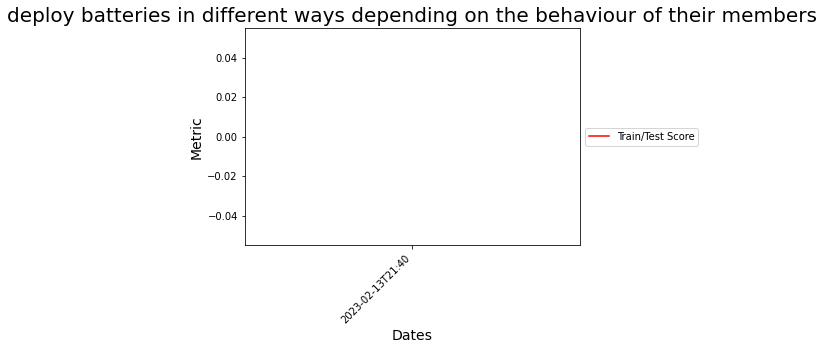

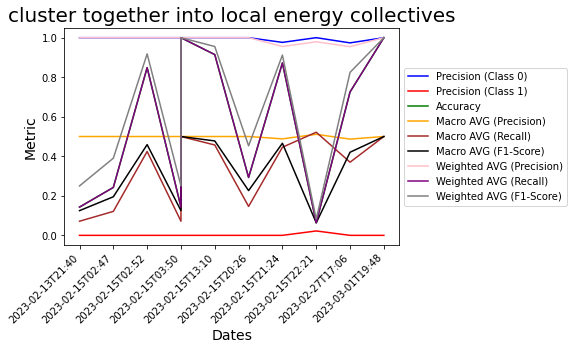

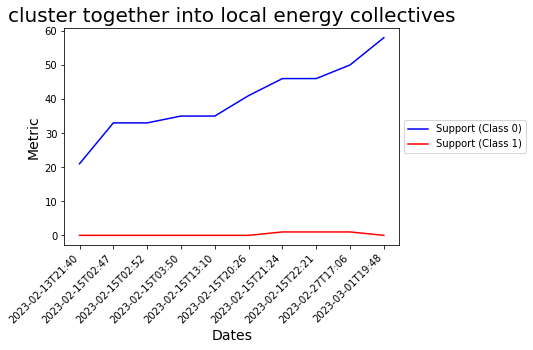

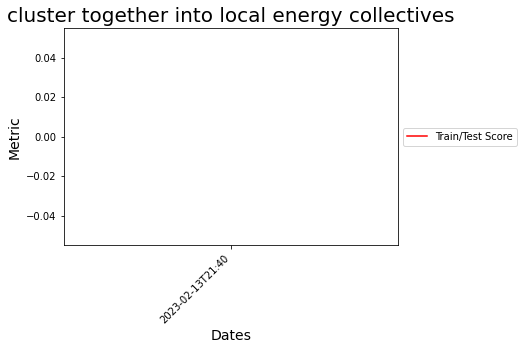

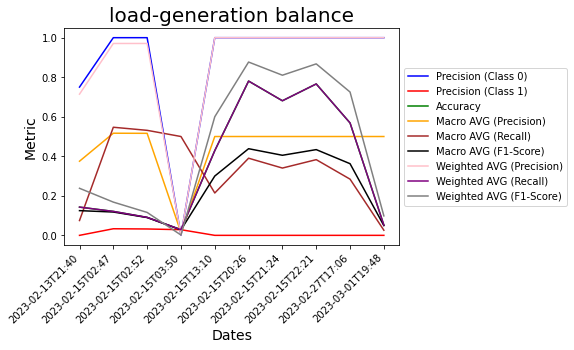

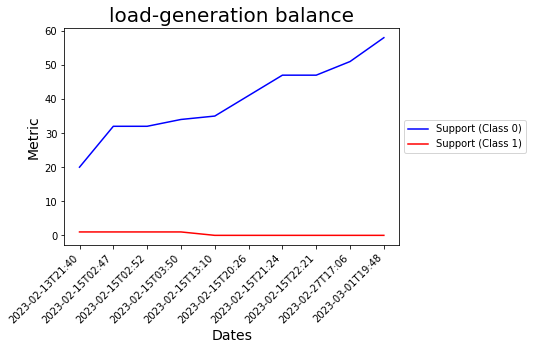

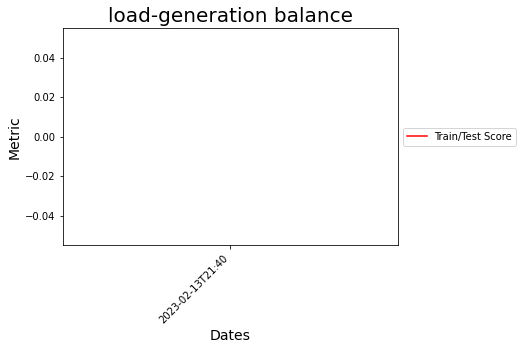

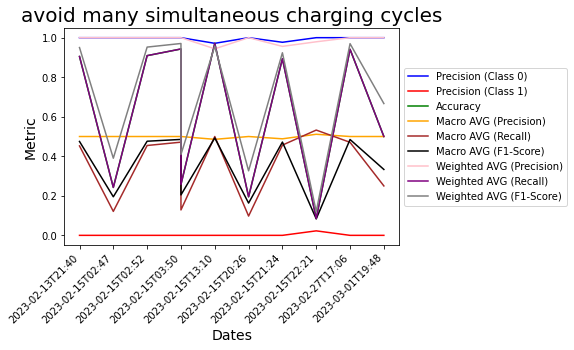

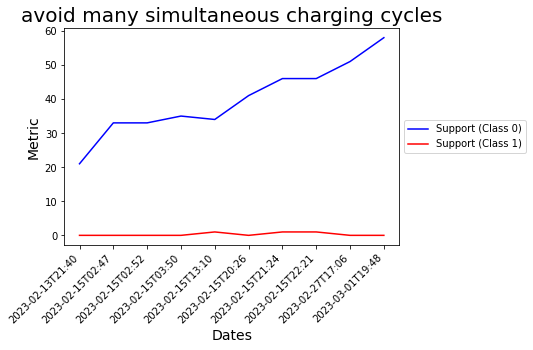

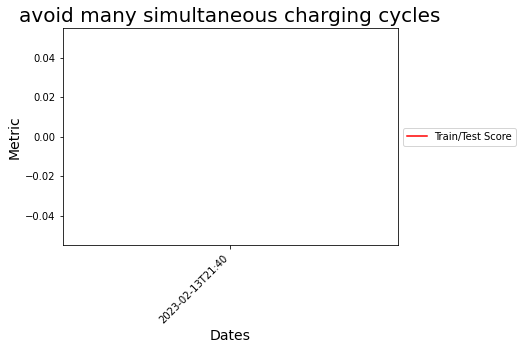

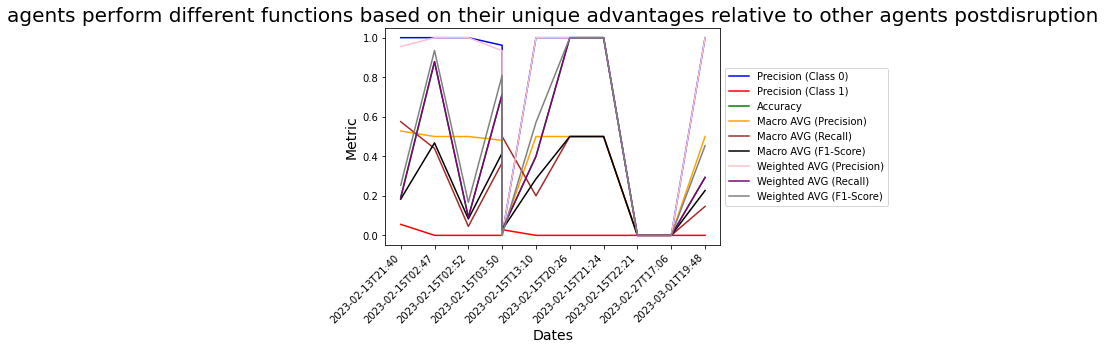

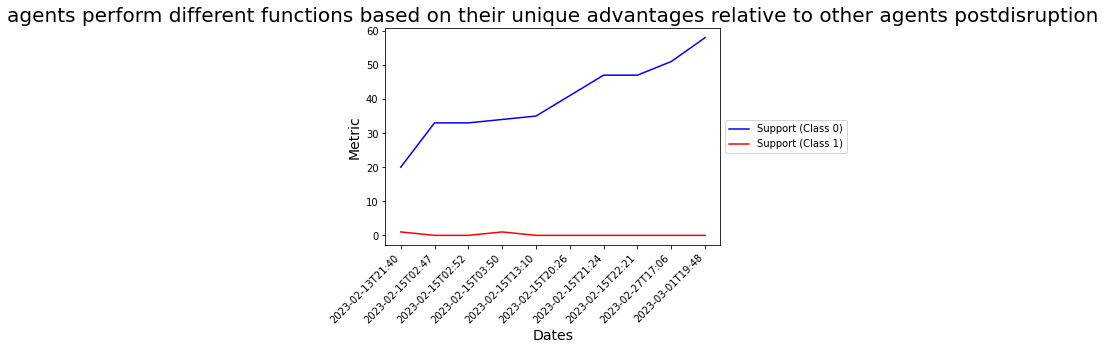

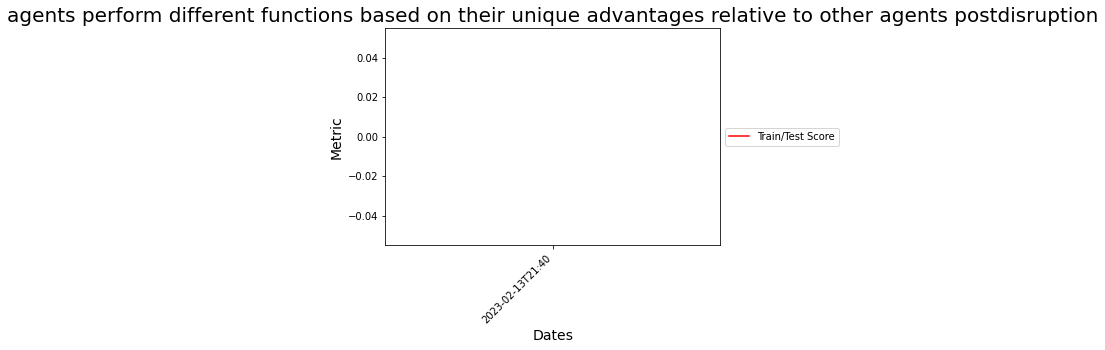

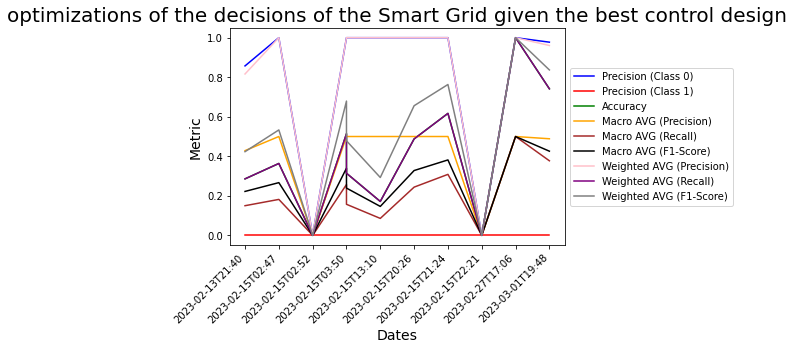

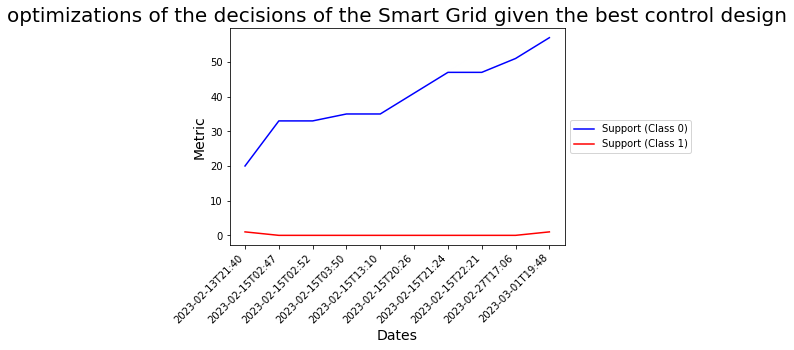

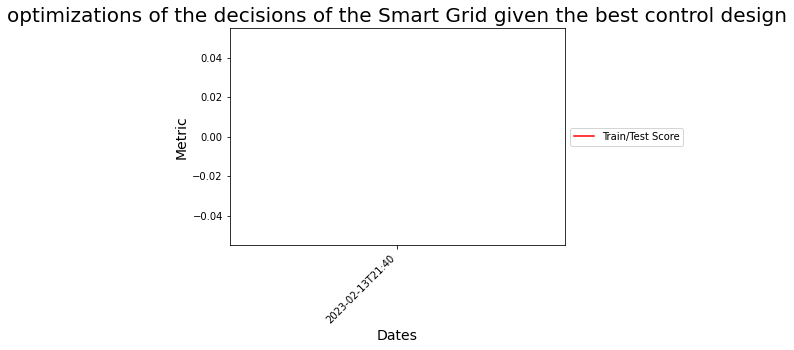

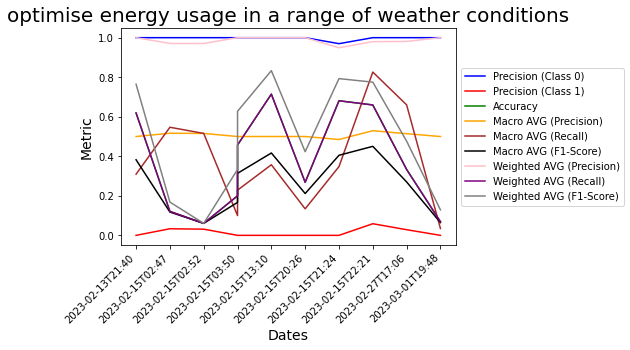

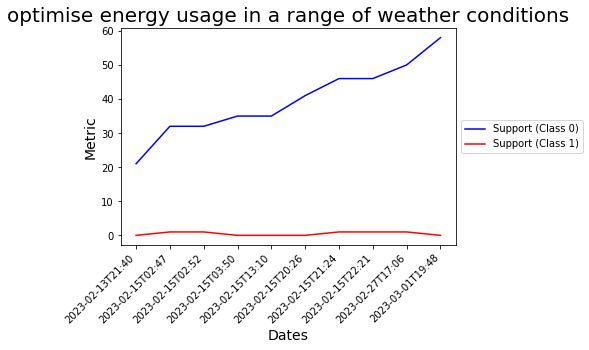

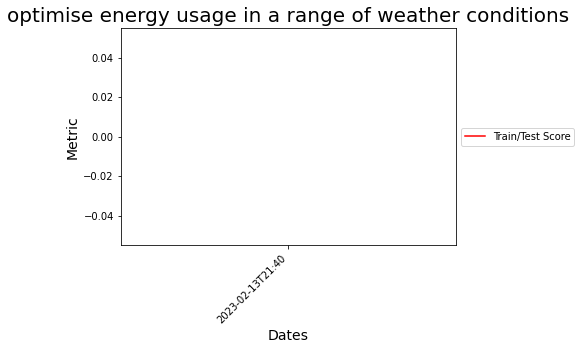

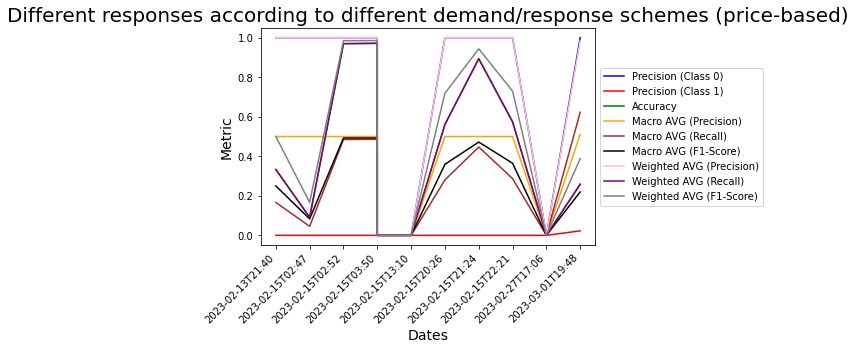

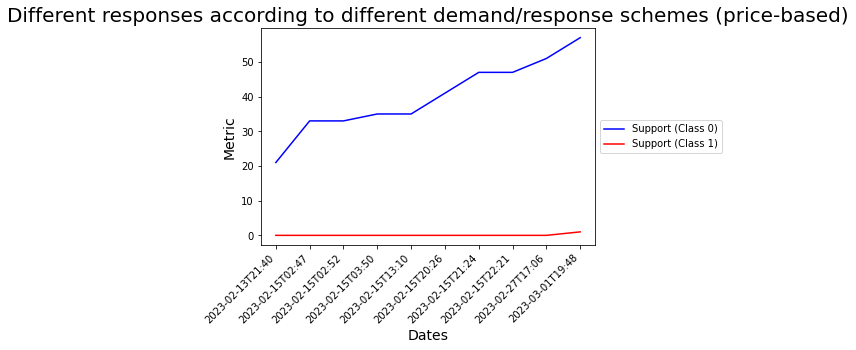

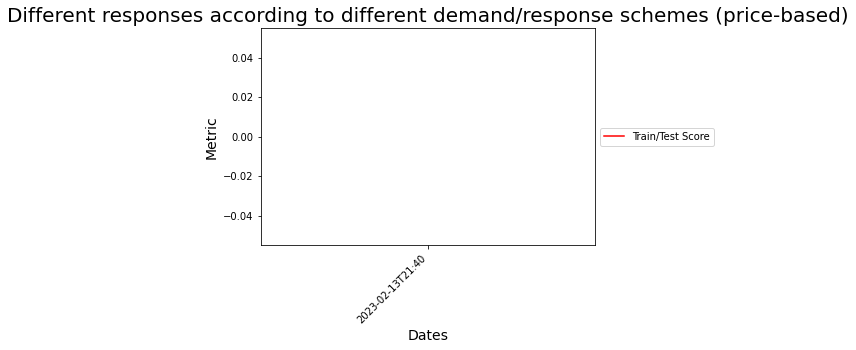

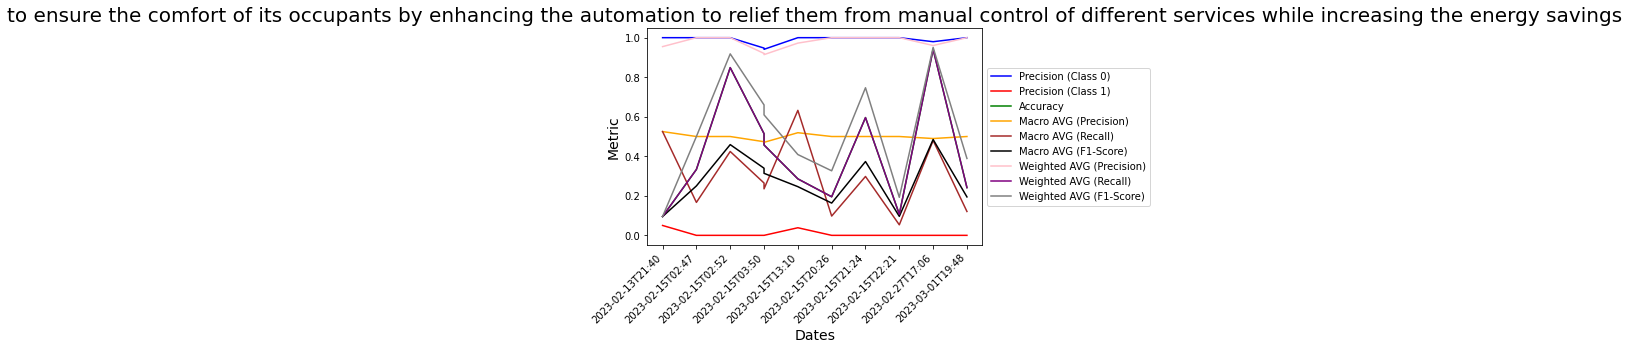

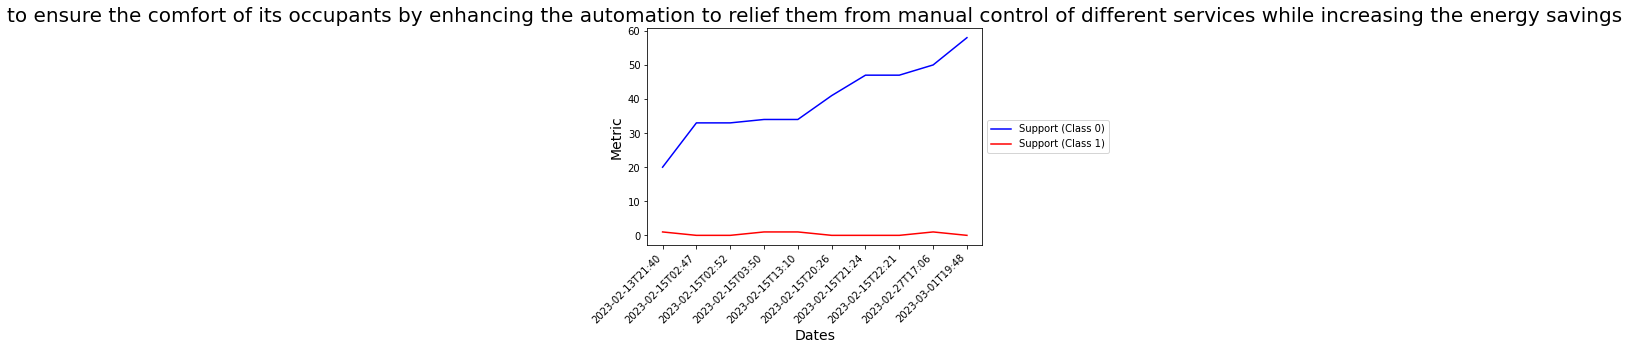

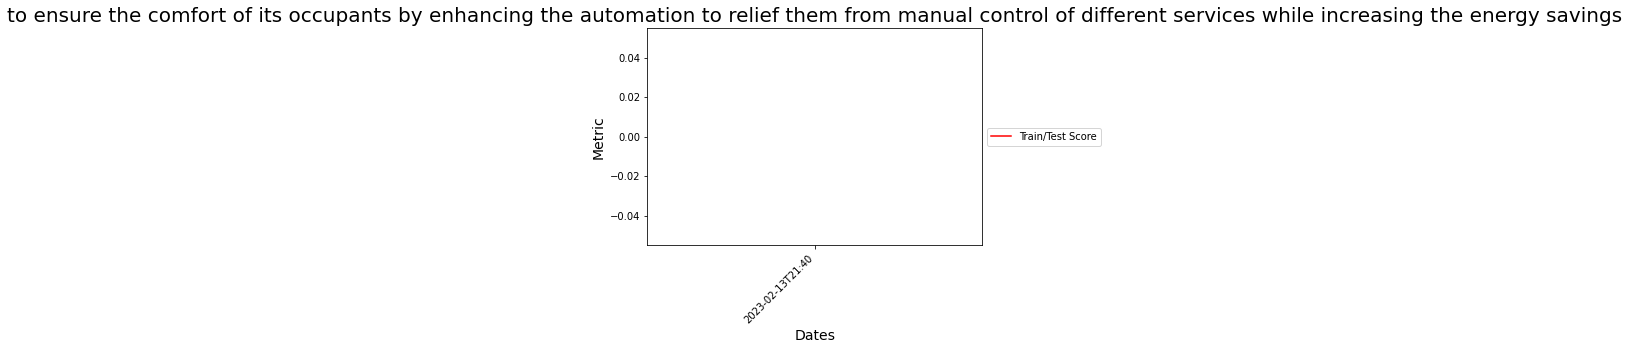

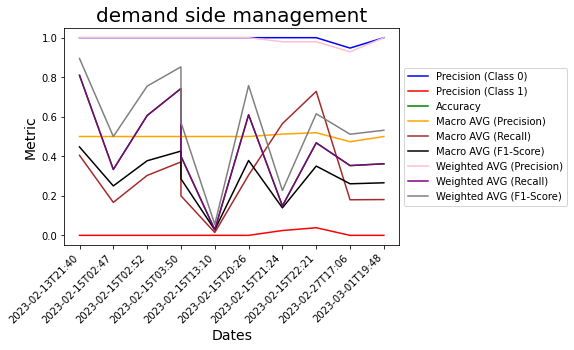

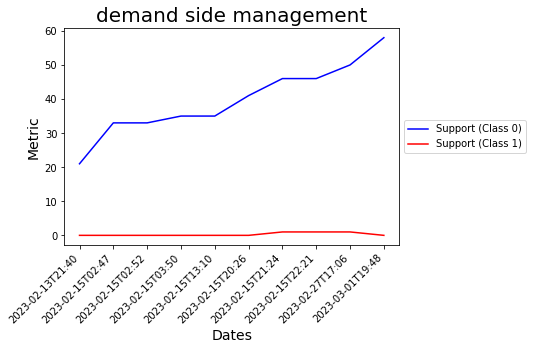

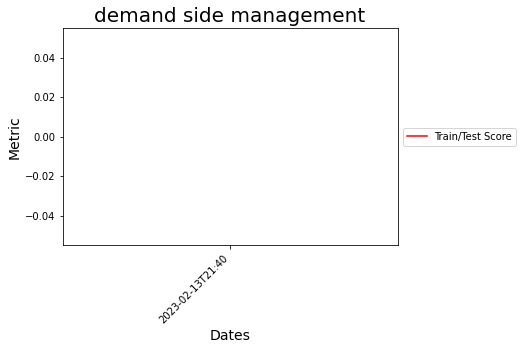

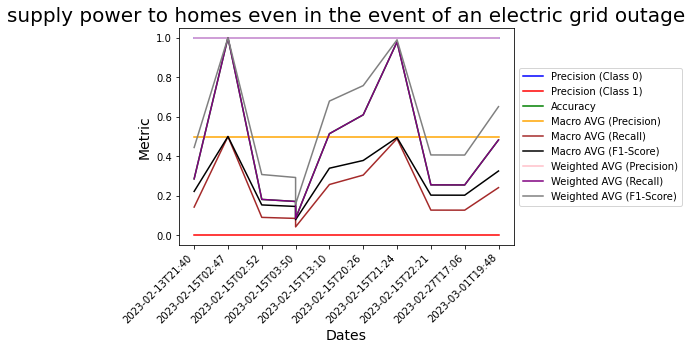

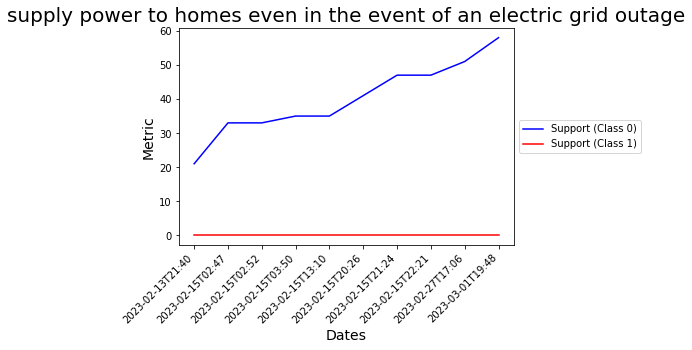

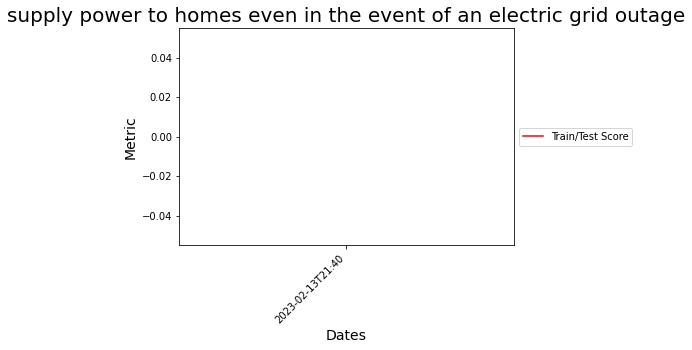

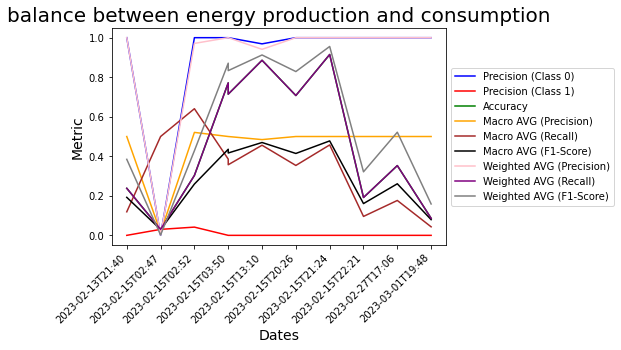

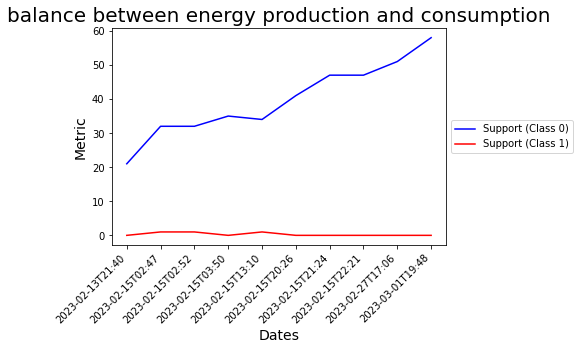

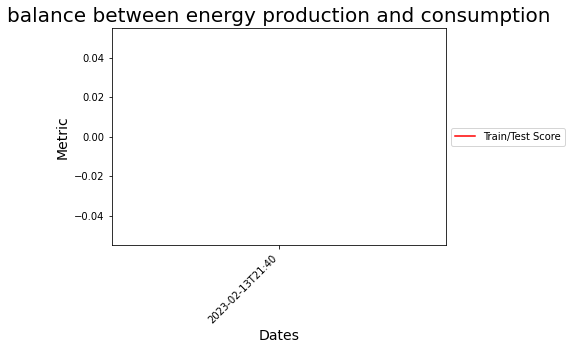

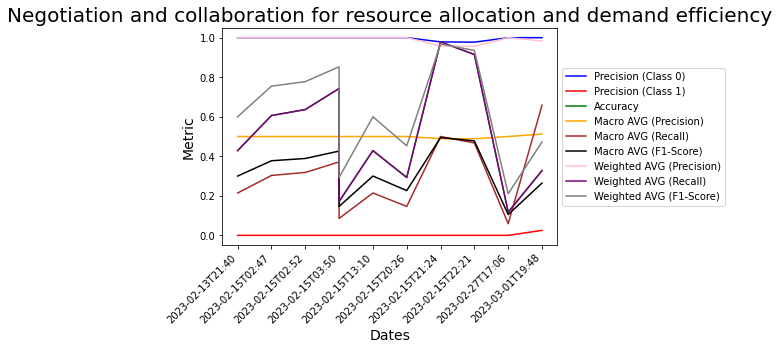

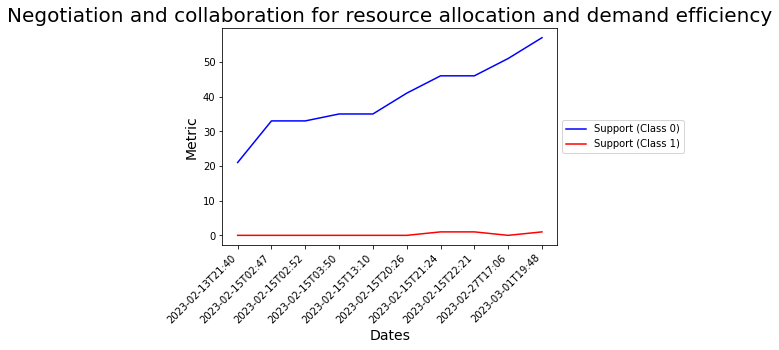

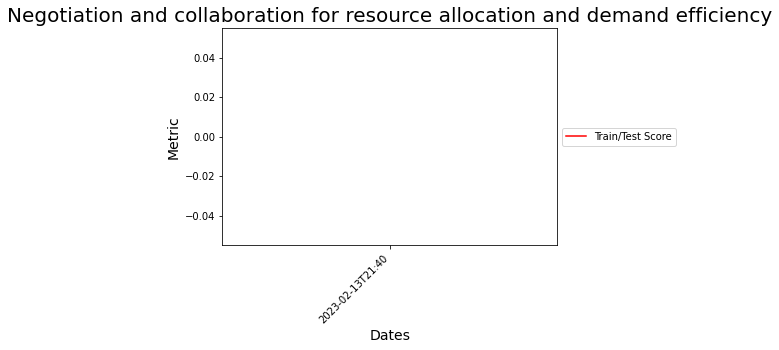

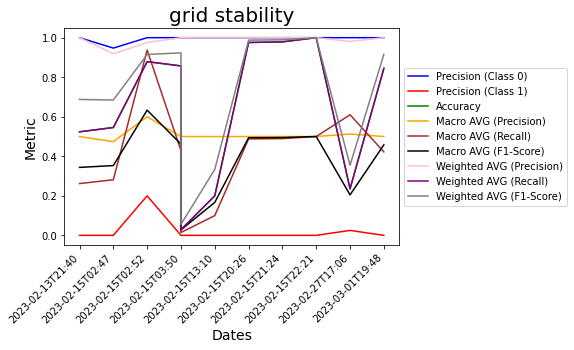

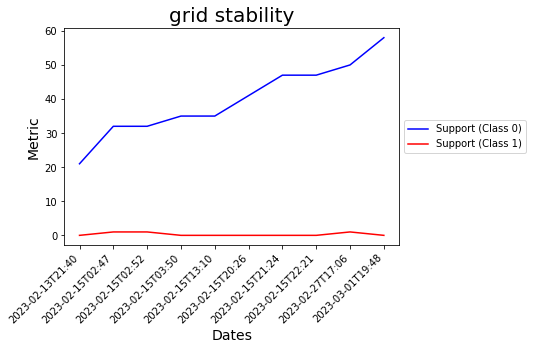

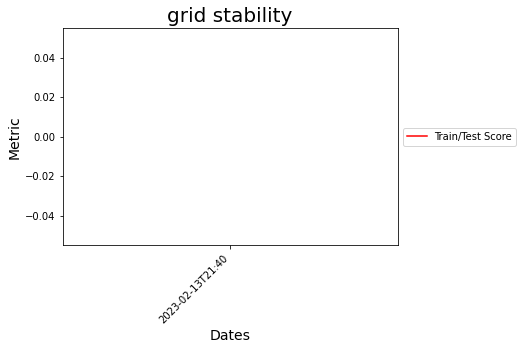

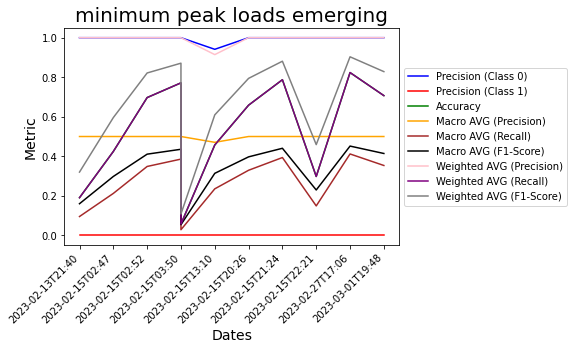

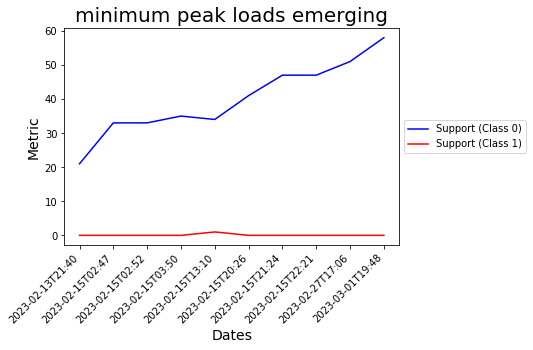

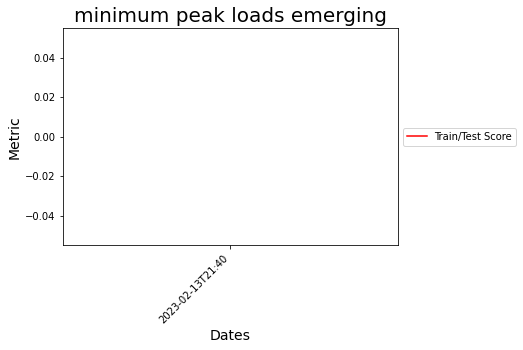

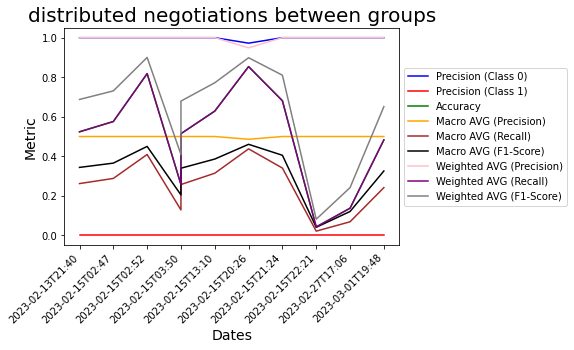

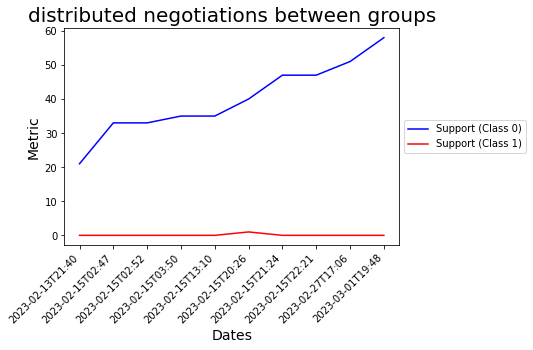

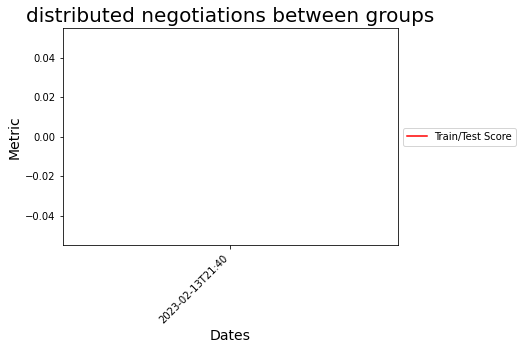

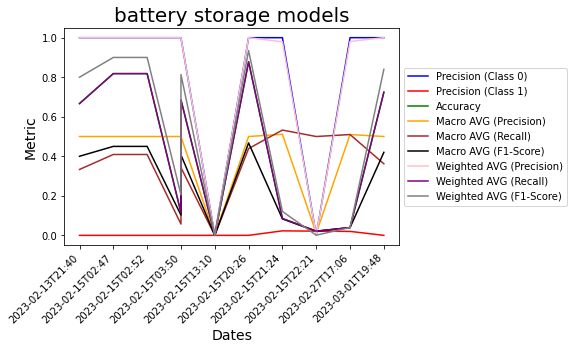

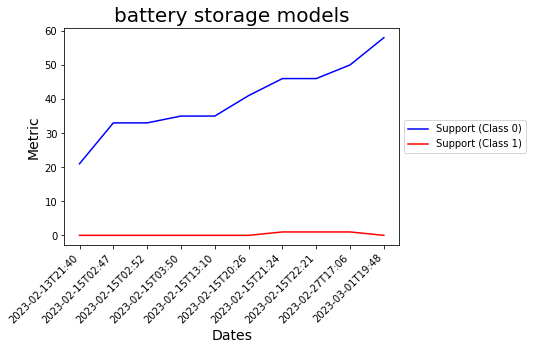

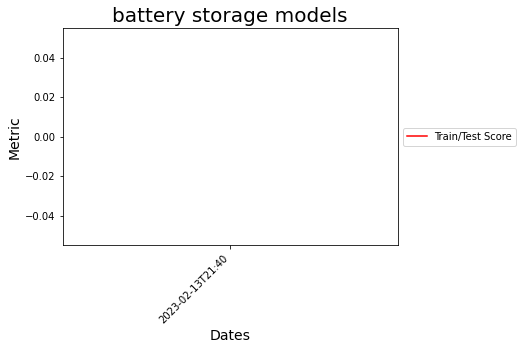

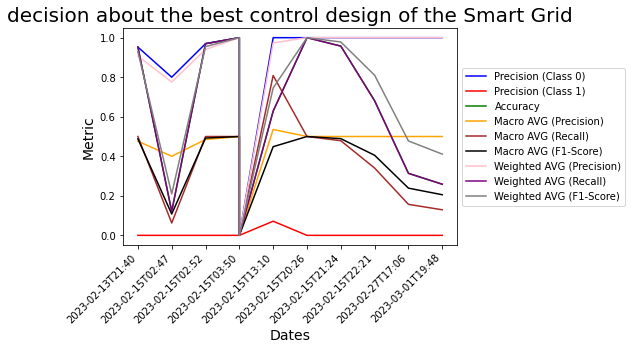

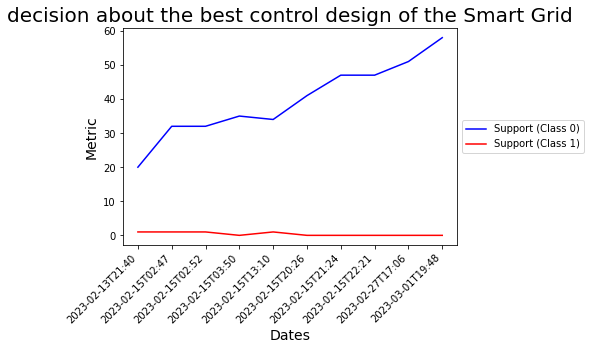

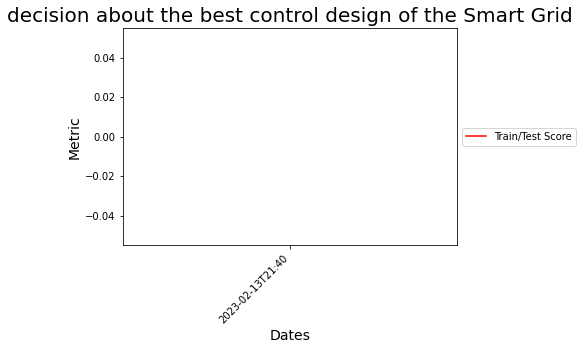

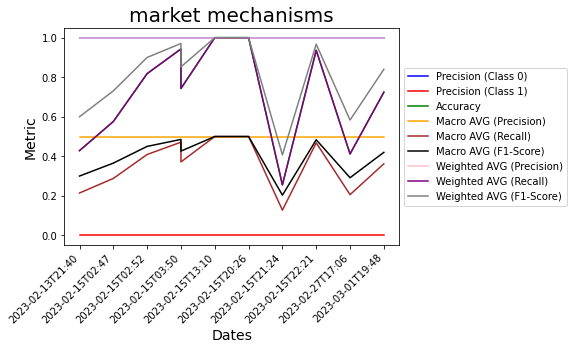

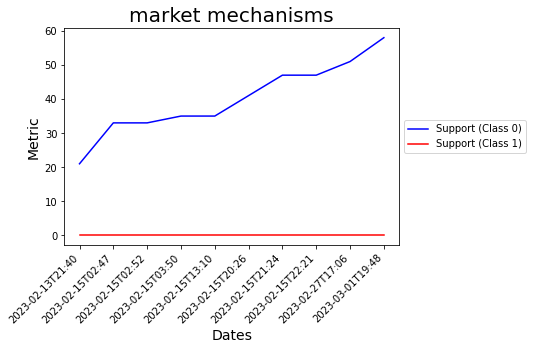

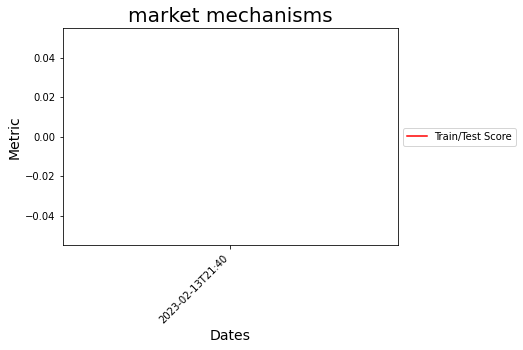

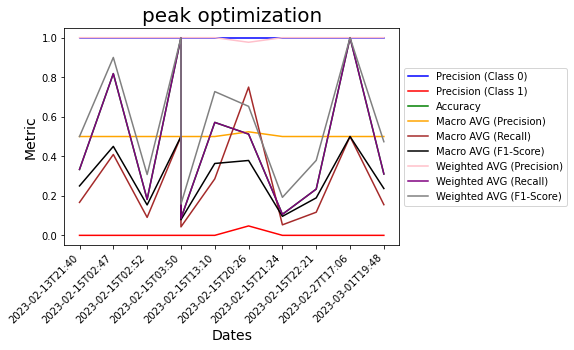

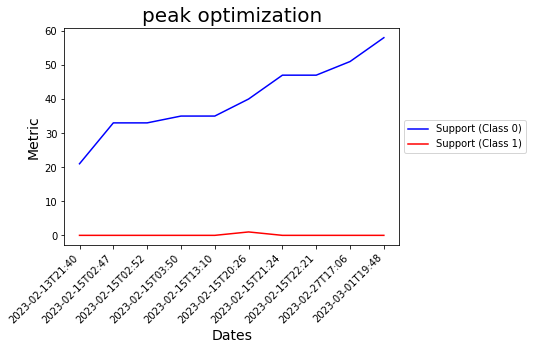

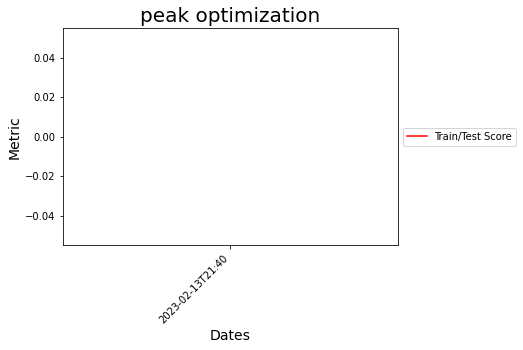

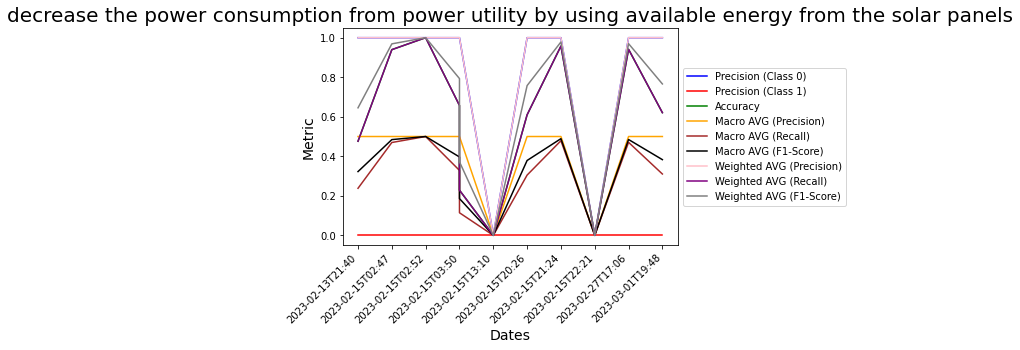

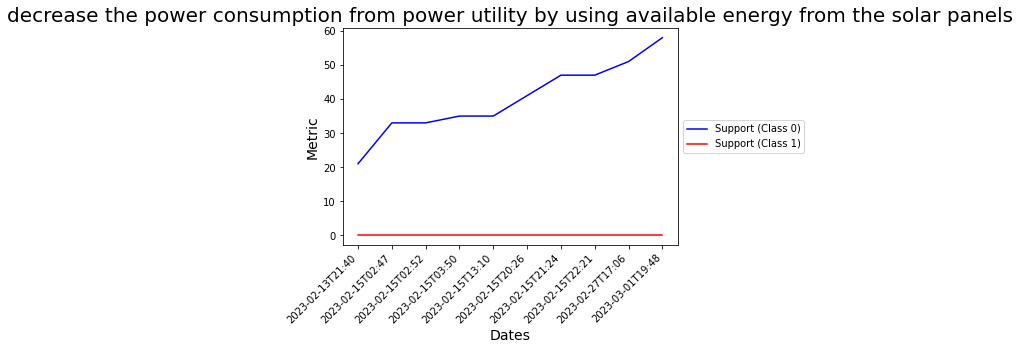

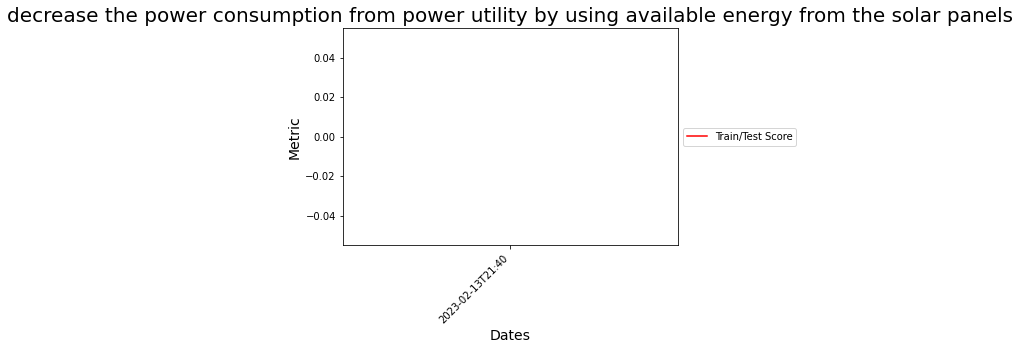

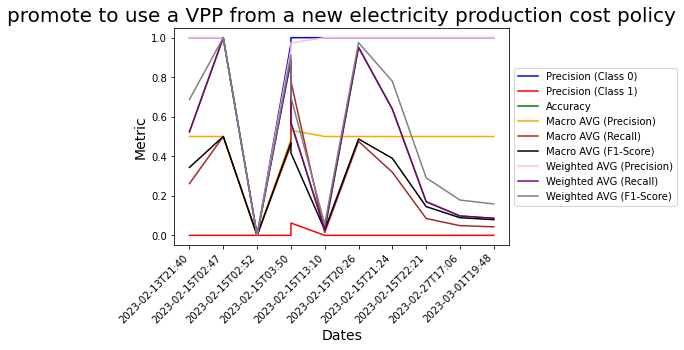

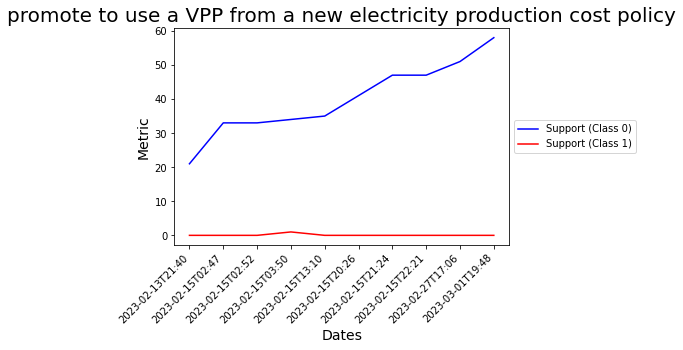

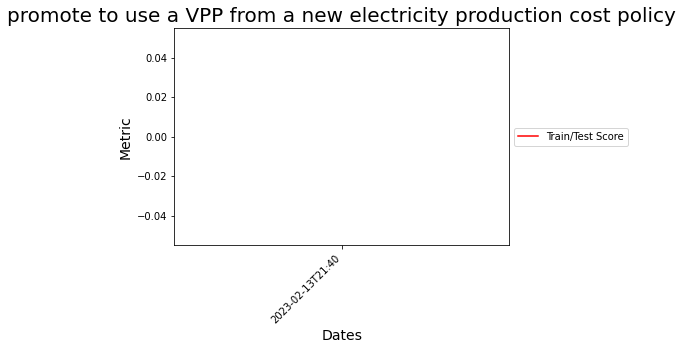

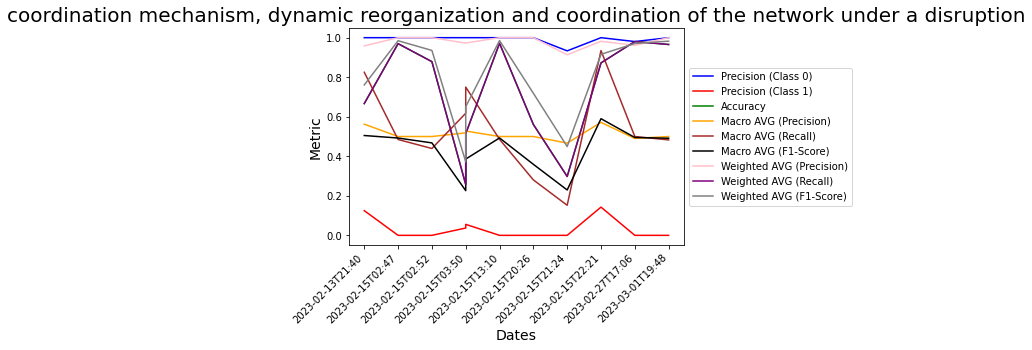

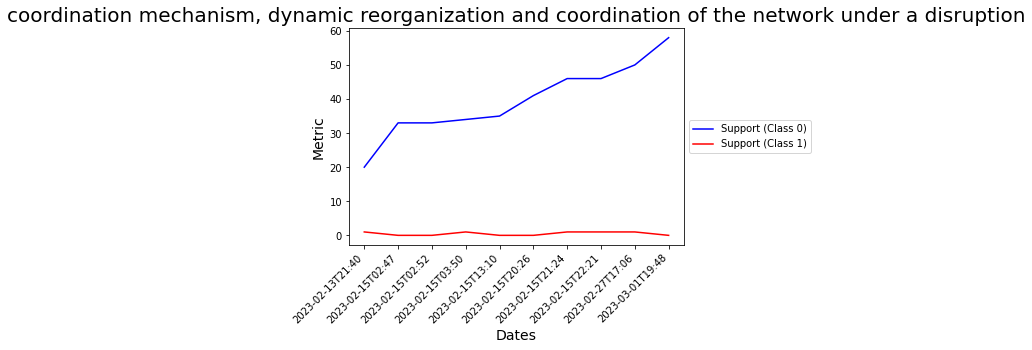

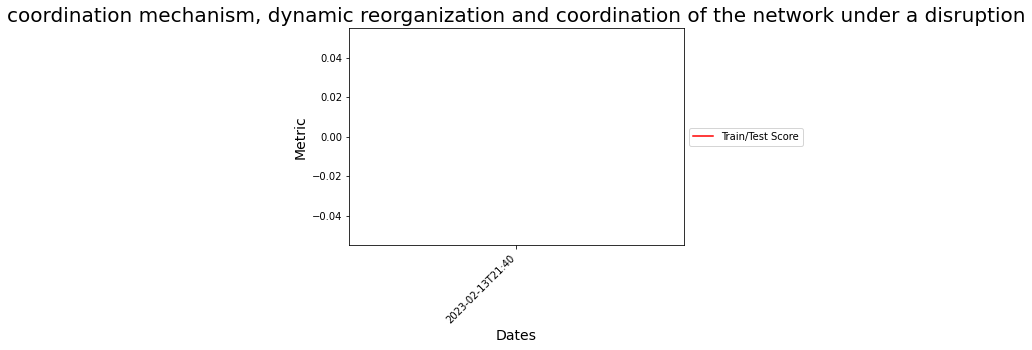

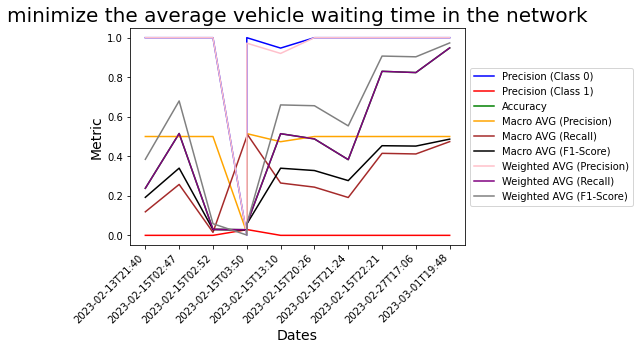

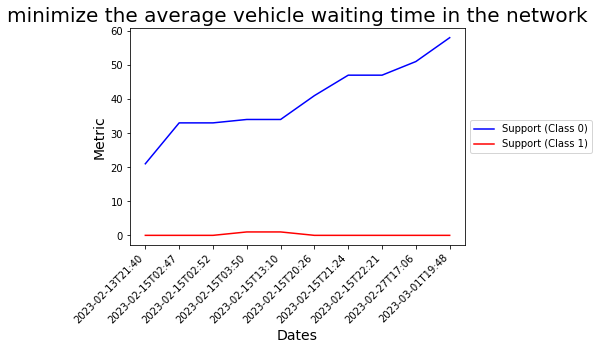

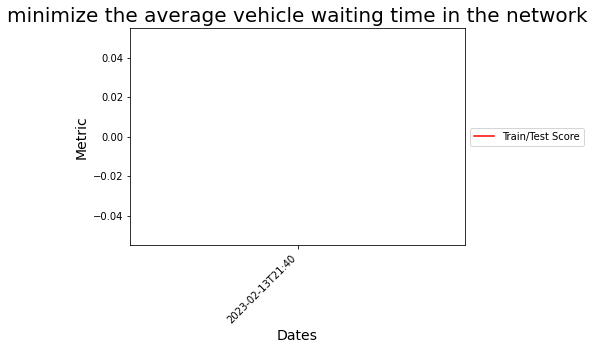

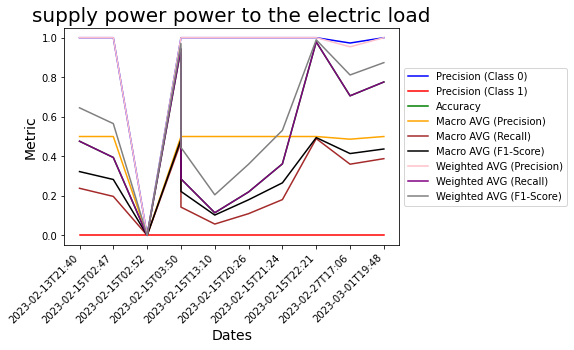

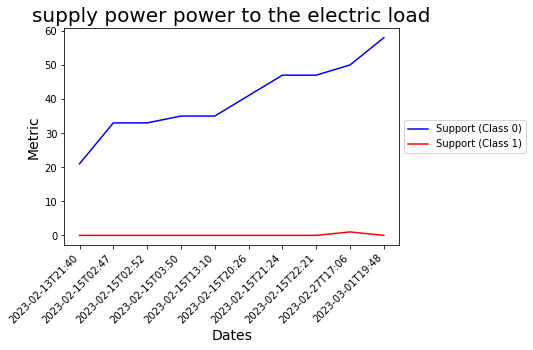

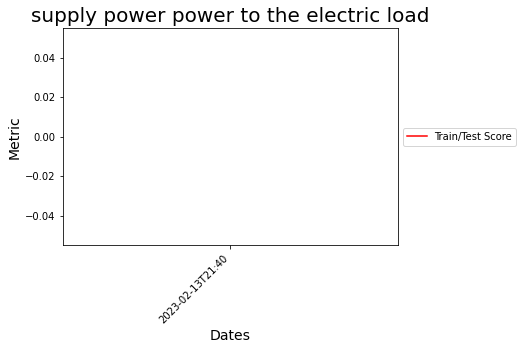

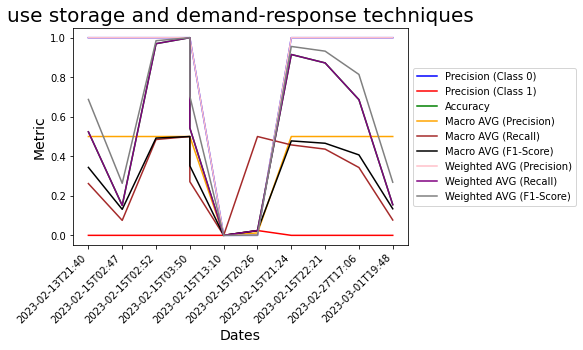

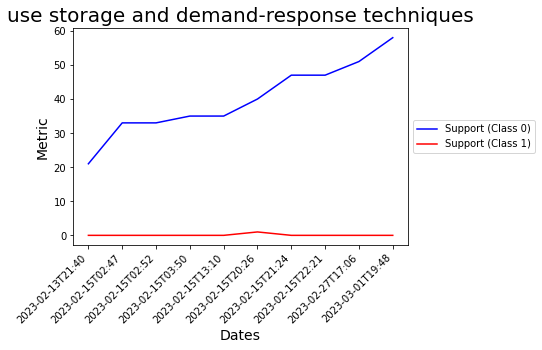

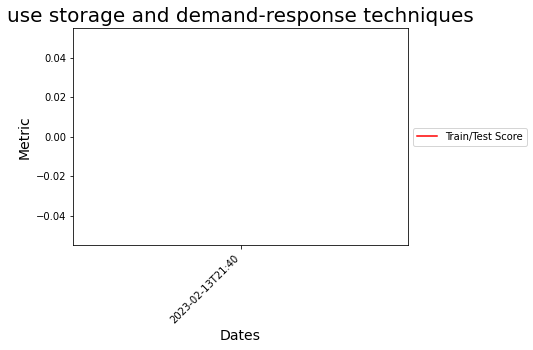

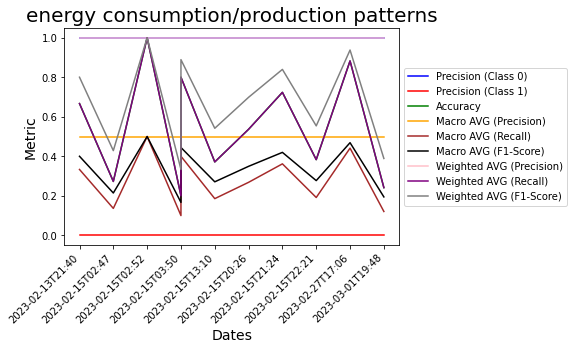

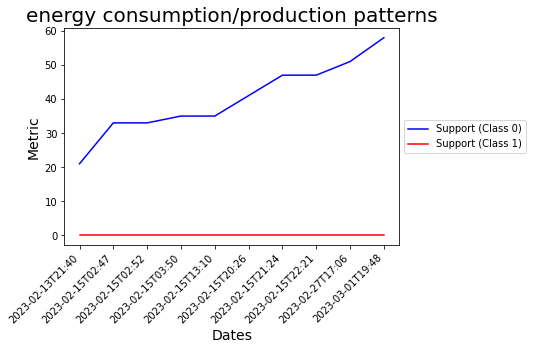

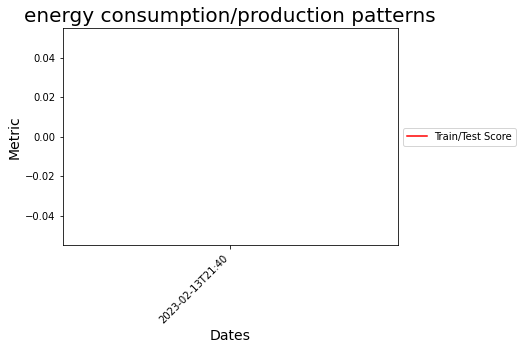

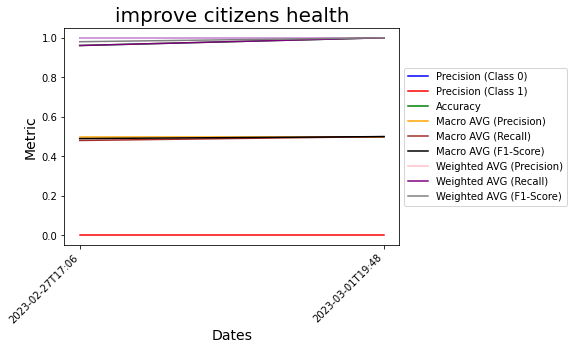

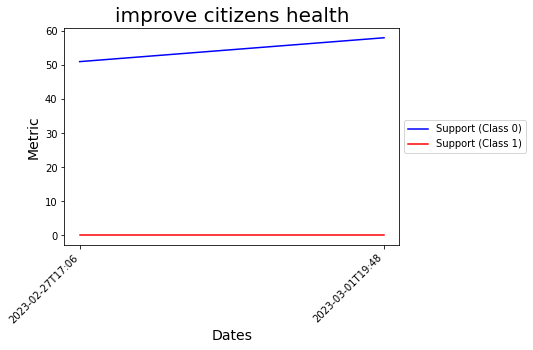

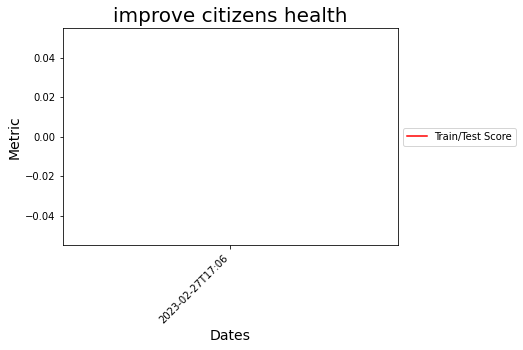

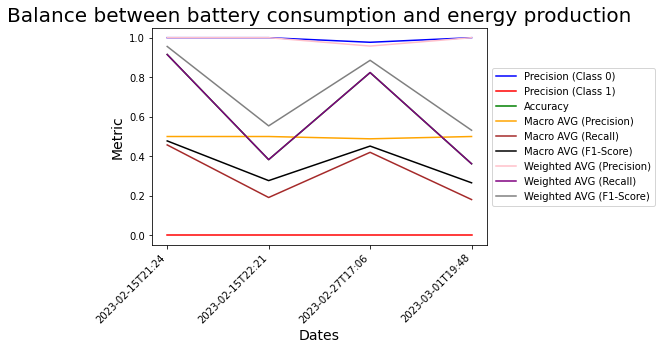

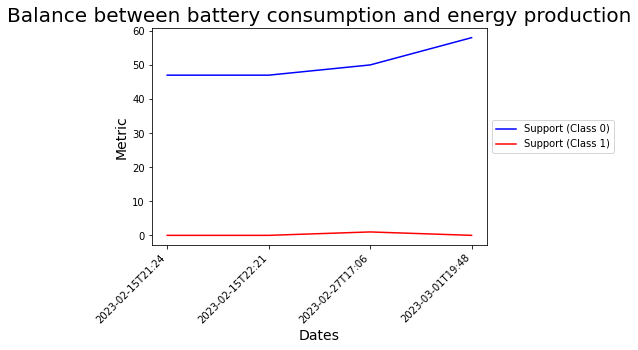

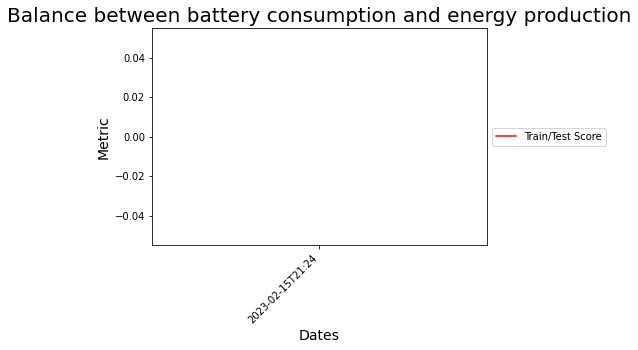

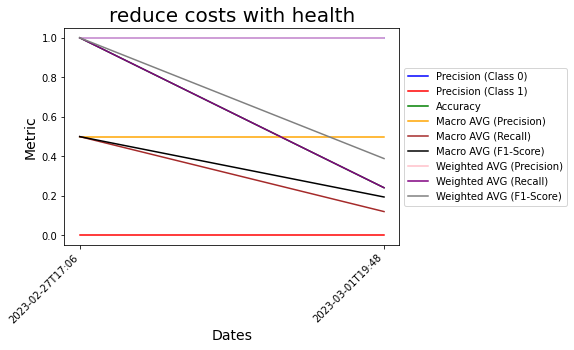

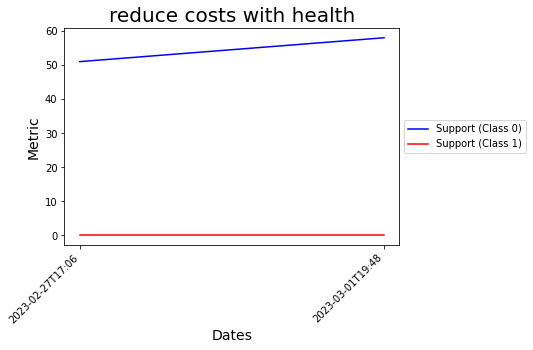

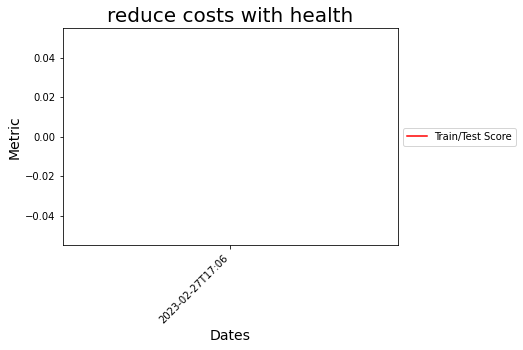

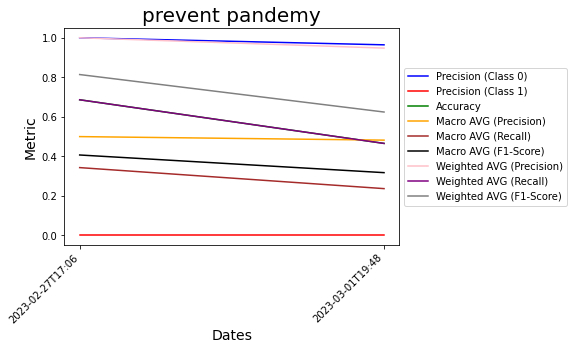

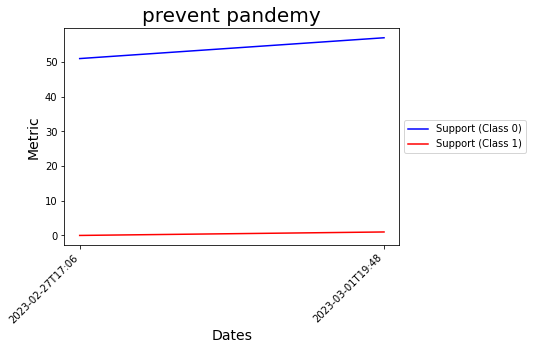

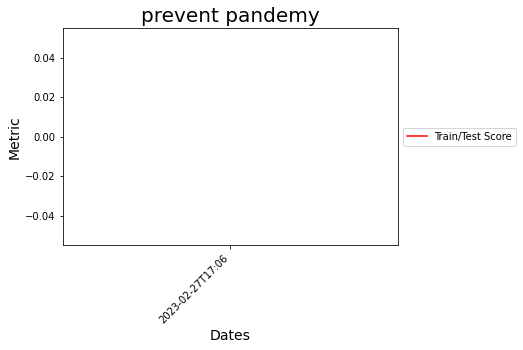

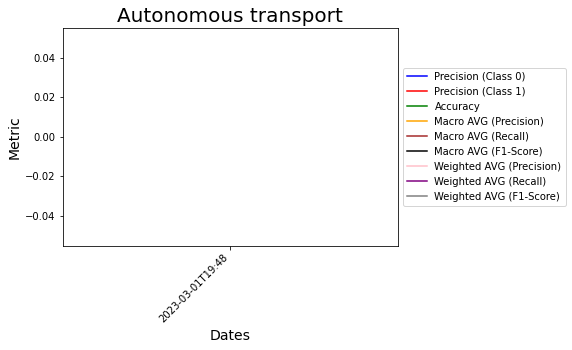

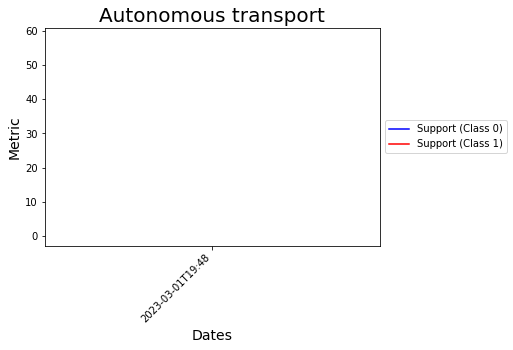

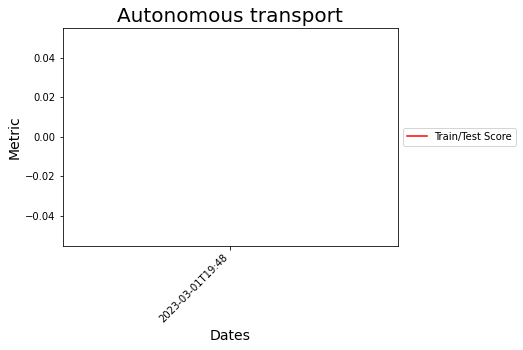

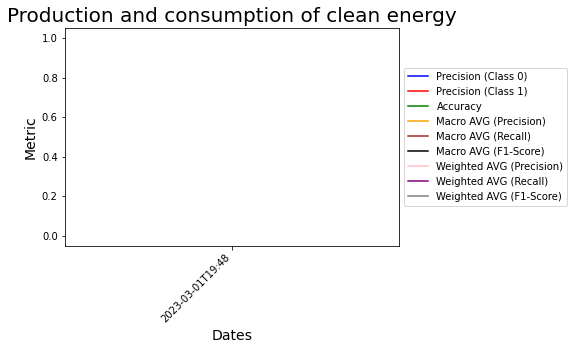

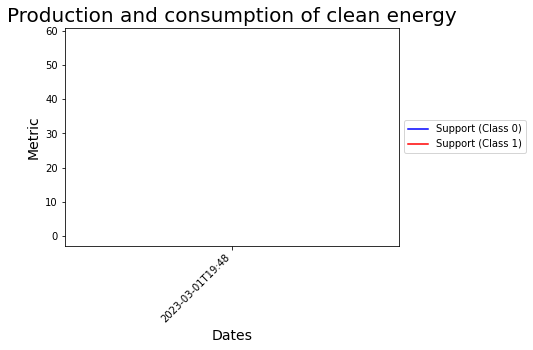

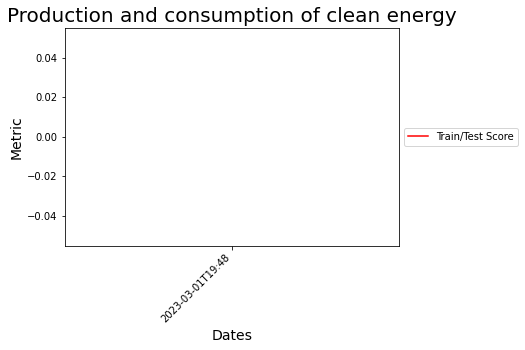

In [17]:
generatePlots(dict_emergent_behaviors)